In [ ]:
import random
import numpy as np
import torch

EPOCHS = 50

# ============================================================
# 1. ÂïüÁî®Â§öÊ†∏ÂøÉÂä†ÈÄü (Ë¶ÅÂú®ÊúÄÂâçÈù¢ÂëºÂè´)
# ============================================================
torch.set_num_threads(torch.get_num_threads())
print("‰ΩøÁî® CPU threads:", torch.get_num_threads())

# ============================================================
# 2. Âõ∫ÂÆöÈö®Ê©üÁ®ÆÂ≠ê (PyTorch / NumPy / Python random)
# ============================================================
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# cudnn Ë®≠ÂÆö (Á¢∫‰øùÁµêÊûúÂÆåÂÖ®ÂèØÈáçÁèæÔºå‰ΩÜÂèØËÉΩÊúÉÁ®çÂæÆËÆäÊÖ¢)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ============================================================
# 3. Ë£ùÁΩÆË®≠ÂÆö (CPU / GPU)
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("‰ΩøÁî®Ë£ùÁΩÆ:", device)



‰ΩøÁî® CPU threads: 16
‰ΩøÁî®Ë£ùÁΩÆ: cpu


# Variational Autoencoder (VAE) ÈÇèËºØÊµÅÁ®ã

---

## 1. ÂïèÈ°åËÉåÊôØ
- **Autoencoder (AE)**ÔºöËº∏ÂÖ• ‚Üí Encoder ‚Üí Decoder ‚Üí ÈáçÂª∫Ëº∏Âá∫„ÄÇ  
- **ÈôêÂà∂**ÔºöLatent space Áº∫‰πèÊ©üÁéáÁµêÊßãÔºåÈõ£‰ª•ÁîüÊàêÊñ∞Ê®£Êú¨„ÄÇ  
- **VAE ÁõÆÊ®ô**Ôºö
  - Â∞áËº∏ÂÖ•ÂΩ±ÂÉèÊò†Â∞ÑÂà∞‰∏ÄÂÄã**Ê©üÁéáÂàÜÂ∏É**ÔºàÂùáÂÄº $\mu$„ÄÅËÆäÁï∞Êï∏ $\sigma^2$Ôºâ„ÄÇ  
  - Âª∫Á´ãË¶èÁØÑÂåñÁöÑ latent spaceÔºåÊîØÊåÅÁîüÊàêÊñ∞Ë≥áÊñô„ÄÇ  

---

## 2. Ë≥áÊñôÊµÅËàáÁ∂≠Â∫¶

- **Ëº∏ÂÖ•**ÔºöMNIST ÂúñÁâá $x$ÔºåÂΩ¢ÁãÄ $(B, 1, 28, 28)$  
- **Â±ïÂπ≥**Ôºö$(B, 784)$  

### Encoder
- $(B, 784) \;\to\; (B, h\_dim)$  
- ÂÖ©ÂÄãËº∏Âá∫Ôºö
  - $\mu = fc21(h) \;\;\;(B, z\_dim)$  
  - $\text{logvar} = fc22(h) \;\;\;(B, z\_dim)$  

### Reparameterization
- $\sigma = \exp \left( \tfrac{1}{2} \cdot \text{logvar} \right)$  
- $\epsilon \sim \mathcal{N}(0, I)$  
- $z = \mu + \sigma \cdot \epsilon$  
- ÁµêÊûúÂΩ¢ÁãÄ $(B, z\_dim)$  

### Decoder
- $(B, z\_dim) \;\to\; (B, h\_dim) \;\to\; (B, 784)$  
- reshape ‚Üí $(B, 1, 28, 28)$  
- **Ëº∏Âá∫ÁØÑÂúçÂèØ‰ª•ÊúâÂÖ©Á®Æ‰ΩúÊ≥ï**Ôºö  
  1. **Sigmoid ‚Üí [0,1]**ÔºöÈÅ©ÂêàÂΩ±ÂÉèÊú¨‰æÜÂ∞±Âú® [0,1]  
  2. **Tanh ‚Üí [-1,1]**ÔºöÂ∏∏Áî®ÊñºÁîüÊàêÊ®°Âûã (GAN, Diffusion)ÔºåÈúÄË¶ÅÂ∞áÂΩ±ÂÉèÈ†êËôïÁêÜÂà∞ [-1,1]  
---

## 3. ÊêçÂ§±ÂáΩÊï∏

### Reconstruction Loss

#### Ëã•Ëº∏Âá∫Âú® `[0,1]`
- ÈáçÂª∫Ë™§Â∑ÆÔºö‰ΩøÁî® **Binary Cross Entropy (BCE)**  
$$
\text{BCE}(x, \hat{x}) = -\sum \big[ x \log \hat{x} + (1-x)\log(1-\hat{x}) \big]
$$

#### Ëã•Ëº∏Âá∫Âú® `[-1,1]`
- ÈáçÂª∫Ë™§Â∑ÆÔºöÂ∏∏Áî® **MSE (Mean Squared Error)**  
$$
\text{MSE}(x, \hat{x}) = \sum (x - \hat{x})^2
$$

### KL Divergence
- ËÆìËøë‰ººÂæåÈ©óÂàÜÂ∏É $q(z|x)$ Êé•ËøëÊ®ôÊ∫ñÂ∏∏ÊÖã $p(z) = \mathcal{N}(0, I)$Ôºö  
$$
\text{KL}(q(z|x) \parallel p(z))
= -\tfrac{1}{2} \sum \left( 1 + \text{logvar} - \mu^2 - \exp(\text{logvar}) \right)
$$

### Á∏ΩÊêçÂ§±
$$
L = \text{Reconstruction} + \text{KL}
$$

---

## 4. Ë®ìÁ∑¥Ê≠•È©üÔºàÊØèÂÄã batchÔºâ

1. **ÂâçÂêëÂÇ≥ÈÅû**  
   - $\mu, \text{logvar} = \text{Encoder}(x)$  
   - $z = \text{reparameterize}(\mu, \text{logvar})$  
   - $\hat{x} = \text{Decoder}(z)$  

2. **Ë®àÁÆóÊêçÂ§±**  
   - Ëã•Ëº∏Âá∫ `[0,1]` ‚Üí Áî® BCE  
   - Ëã•Ëº∏Âá∫ `[-1,1]` ‚Üí Áî® MSE
   - Âä†‰∏ä $\text{KL}(\mu, \text{logvar})$  

3. **ÂèçÂêëÂÇ≥ÈÅûËàáÊõ¥Êñ∞**  
   - $loss = \text{Reconstruction} + \text{KL}$  
   - $loss.\text{backward()}$  
   - $optimizer.\text{step()}$  

---

## 5. Á®ãÂºèÁ¢ºÂ∞çÊáâ

- **fc21, fc22** ‚Üí Encoder ÂÖ©ÂÄãËº∏Âá∫È†≠ÔºåÂàÜÂà•Ë®àÁÆó $\mu$„ÄÅlogvar  
- **reparameterize()** ‚Üí Â∞á $(\mu, \text{logvar})$ ËΩâÁÇ∫ $z$  
- **vae_loss()** ‚Üí Ë®àÁÆó BCE + KL  
- **forward()** ‚Üí ‰∏≤Êé•ÂÆåÊï¥ÊµÅÁ®ã  

---

## 6. Êï¥È´îÈÇèËºØÊëòË¶Å

- **Encoder**ÔºöÂ≠∏ÁøíËº∏ÂÖ•ÁöÑÂàÜÂ∏ÉÂèÉÊï∏ $(\mu, \text{logvar})$  
- **Reparameterization**ÔºöÂà©Áî® reparameterization trickÔºåÁîüÊàêÂèØÂæÆÂàÜÁöÑ latent ÂêëÈáè $z$  
- **Decoder**ÔºöÁî± latent ÂêëÈáè $z$ ÈáçÂª∫Ëº∏ÂÖ•  
- **Loss**Ôºö$\text{Reconstruction} + \text{KL}$ÔºåÂÖ∂‰∏≠  
  - **Ëã•Ë≥áÊñô/Ëº∏Âá∫Âú® `[0,1]`**Ôºö`Decoder=Sigmoid`Ôºå`Reconstruction=BCE`  
  - **Ëã•Ë≥áÊñô/Ëº∏Âá∫Âú® `[-1,1]`**Ôºö`Decoder=Tanh`Ôºå`Reconstruction=MSE`  
- **ÊúÄÁµÇÁµêÊûú**ÔºöÊ®°ÂûãÊó¢ËÉΩÈáçÂª∫Ëº∏ÂÖ•ÔºåÂèàËÉΩÈÄèÈÅé latent Á©∫ÈñìÁîüÊàêÊñ∞ÂΩ±ÂÉè


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Êï∏ÊìöÈ†êËôïÁêÜ

# Decoder Ëº∏Âá∫Á∂ì Sigmoid Â£ìÂà∞ [0,1]
transform = transforms.ToTensor()

# Decoder Ëº∏Âá∫Á∂ì Tanh Â£ìÂà∞ [-1,1]
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


batch_size = 128

# ‰∏ãËºâ MNIST Êï∏ÊìöÈõÜ
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

x_train = train_dataset.data    # ÂúñÁâá
y_train = train_dataset.targets # Ê®ôÁ±§
print(f'x_train size: {x_train.size()}')
print(f'y_train size: {y_train.size()}')


x_test = test_dataset.data    # ÂúñÁâá
y_test = test_dataset.targets # Ê®ôÁ±§
print(f'x_test size: {x_test.size()}')
print(f'y_test size: {y_test.size()}')

x_train size: torch.Size([60000, 28, 28])
y_train size: torch.Size([60000])
x_test size: torch.Size([10000, 28, 28])
y_test size: torch.Size([10000])


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image


# =============================
# 1. ÂÆöÁæ© VAE Ê®°Âûã
# =============================

class VAE(nn.Module):
    def __init__(self, z_dim=20, h_dim=400):
        super().__init__()

        self.z_dim = z_dim
        self.h_dim = h_dim

        # EncoderÔºöÊääËº∏ÂÖ•ÁöÑ 784 Á∂≠ÂΩ±ÂÉèÂ£ìÁ∏Æ
        self.fc1  = nn.Linear(28 * 28, h_dim)   # (784 ‚Üí h_dim)
        self.fc21 = nn.Linear(h_dim, z_dim)     # (h_dim ‚Üí z_dim) Ëº∏Âá∫ Œº
        self.fc22 = nn.Linear(h_dim, z_dim)     # (h_dim ‚Üí z_dim) Ëº∏Âá∫ logœÉ¬≤

        # DecoderÔºöÊää z ÈÇÑÂéüÂõû 784 Á∂≠ÂΩ±ÂÉè
        self.fc3  = nn.Linear(z_dim, h_dim)     # (z_dim ‚Üí h_dim)
        self.fc4  = nn.Linear(h_dim, 28 * 28)   # (h_dim ‚Üí 784)

    def encode(self, x):
        # x: (B, 784)ÔºõÂÖàÈÅé‰∏ÄÂ±§ÈùûÁ∑öÊÄßÂèñË°®Âæµ h
        h = torch.relu(self.fc1(x))

        # ‰ª•Âêå‰∏ÄÂÄã hÔºåÂêÑËá™Á∂ìÈÅé‰∏çÂêåÁ∑öÊÄßÂ±§ÔºåÂæóÂà∞ Œº Ëàá logœÉ¬≤
        # ÂÖ©ÂÄã head ÁµêÊßãÁõ∏ÂêåÔºå‰ΩÜÊ¨äÈáçÁç®Á´ã ‚Üí ËÉΩËº∏Âá∫‰∏çÂêåÂÄº
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mu, logvar):
        # ÈáçÂèÉÊï∏ÂåñÔºöz = Œº + œÉ * ŒµÔºåÂÖ∂‰∏≠ œÉ = exp(0.5 * logœÉ¬≤)
        std = torch.exp(0.5 * logvar)

        # ÈÄêÂÖÉÁ¥†ÊäΩÊ®£ Œµ ~ N(0,1)ÔºåÂΩ¢ÁãÄÂêå std
        eps = torch.randn_like(std)

        # ÈÄôÂÄãÂØ´Ê≥ïËÆì z Â∞ç Œº„ÄÅlogvar ÂèØÂæÆÔºåÊúâÂä©ÂèçÂÇ≥Êõ¥Êñ∞ Encoder
        return mu + eps * std

    def decode(self, z):
        # ÂÖàÊää z ÊäïÂΩ±ÂõûÈö±ËóèÂ±§ÔºåÂÜçËº∏Âá∫ 784 Á∂≠ÁöÑÈáçÂª∫ÂêëÈáè
        h = torch.relu(self.fc3(z))

        # Áî® sigmoid Â£ìÂà∞ [0,1]ÔºåÂ∞çÊáâÂÉèÁ¥†Ê©üÁéá/Âº∑Â∫¶
        return torch.sigmoid(self.fc4(h))   # ‚Üí (B, 784) in [0,1]

    def forward(self, x):
        # Êé•ÂèóÂΩ±ÂÉè (B,1,28,28) Êàñ (B,28,28)ÔºåÁµ±‰∏ÄÊî§Âπ≥Êàê (B,784)
        x = x.view(-1, 28 * 28)

        # Á∑®Á¢ºÔºöÂæóÂà∞ q(z|x) ÁöÑÂèÉÊï∏ Œº Ëàá logœÉ¬≤
        mu, logvar = self.encode(x)

        # ÂèñÊ®£ÊΩõËÆäÈáè zÔºàÂèØÂæÆÔºâ
        z = self.reparameterize(mu, logvar)

        # Ëß£Á¢ºÔºöÂæóÂà∞ÈáçÂª∫ hat{x}Ôºà‰ªçÊòØ (B,784)Ôºâ
        x_hat = self.decode(z)

        # ÂõûÂÇ≥ÈáçÂª∫ËàáÂèÉÊï∏Ôºå‰æõ loss ‰ΩøÁî®
        return x_hat, mu, logvar


# =============================
# 2. ÂÆöÁæ© Loss ÂáΩÊï∏
# =============================

def vae_loss(recon_x, x, mu, logvar):
    # Ëàá forward ‰∏ÄËá¥ÔºåÁ¢∫‰øù x Ëàá recon_x ÂΩ¢ÁãÄÁõ∏Âêå
    x = x.view(-1, 28 * 28)

    # ‰ΩøÁî® BCE Áï∂ÈáçÂª∫Ë™§Â∑ÆÔºö
    # - Â∞çÊØèÂÄãÂÉèÁ¥†Ë®àÁÆó‰∫§ÂèâÁÜµ (ÂÅáË®≠ÂÉèÁ¥†ÂÄºÁÇ∫ [0,1] ÁöÑÊ©üÁéáÂàÜÂ∏É)
    # - "sum" ‰ª£Ë°®ÂÖàÊääÊï¥ÂÄã batch ÁöÑÊâÄÊúâÂÉèÁ¥†Ë™§Â∑ÆÂä†Á∏Ω
    # - ÂÜçÈô§‰ª• batch Â§ßÂ∞èÔºåÊèõÁÆóÊàê„ÄåÊØèÂºµÂúñÂπ≥ÂùáÁöÑÁ∏ΩË™§Â∑Æ„Äç
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction="sum") / x.size(0)

    # KLÔºöËÆì q(z|x) Èù†Ëøë N(0,I)
    # -0.5 * Œ£ (1 + logœÉ¬≤ - Œº¬≤ - œÉ¬≤)ÔºåÂÜçÈô§ batch ÊàêÊØèÊ®£Êú¨Âπ≥Âùá
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)

    # ÂêåÊôÇÂõûÂÇ≥‰∏âÂÄãÔºöÁ∏Ω loss / BCE / KLDÔºåÊñπ‰æøÁõ£Êéß
    return BCE + KLD, BCE, KLD


# =============================
# 3. ÂàùÂßãÂåñÊ®°ÂûãËàáË®≠ÂÆö
# =============================

vae = VAE(z_dim=20, h_dim=512).to(device)
opt_vae = optim.Adam(vae.parameters(), lr=1e-3)

os.makedirs("samples/vae", exist_ok=True)


# =============================
# 4. Ë®ìÁ∑¥ÊµÅÁ®ã
# =============================

def train_vae(epochs=5):
    # ÂàáÂà∞Ë®ìÁ∑¥Ê®°ÂºèÔºàÂïüÁî® dropout/bn Á≠âË°åÁÇ∫ÔºõÈÄôË£°‰∏ªË¶ÅÊòØÊÖ£‰æãÔºâ
    vae.train()

    # Âõ∫ÂÆö‰∏ÄÁµÑ zÔºåÊñπ‰æøÊØèÂÄã epoch ÂæåËßÄÂØüÁîüÊàêÂúñÁâáÁöÑËÆäÂåñ
    fixed_z = torch.randn(10, vae.z_dim).to(device)

    for epoch in range(1, epochs + 1):
        total_loss, total_bse, total_kld = 0.0, 0.0, 0.0

        for x, _ in train_loader:  # train_loader ÈúÄ‰∫ãÂÖàÊ∫ñÂÇôÂ•ΩÔºåx ‚àà [-1,1] / x ‚àà [0,1]
            # ÊâπÊ¨°ËÆÄË≥áÊñôÔºåÊê¨Âà∞ CPU/GPU
            x = x.to(device)       # (B,1,28,28)

            # ÂâçÂêëÔºöÊãøÂà∞ÈáçÂª∫„ÄÅŒº„ÄÅlogœÉ¬≤
            x_hat, mu, logvar = vae(x)

            # Ë®àÁÆó LossÔºàÊúÉÂêåÊôÇÂæóÂà∞ BCE Ëàá KLDÔºâ
            loss, bse, kld = vae_loss(x_hat, x, mu, logvar)

            # ÂÖ∏ÂûãË®ìÁ∑¥‰∏âÊ≠•È©üÔºöÊ∏ÖÊ¢ØÂ∫¶ ‚Üí ÂèçÂÇ≥ ‚Üí Êõ¥Êñ∞
            opt_vae.zero_grad()
            loss.backward()
            opt_vae.step()

            # Ê≥®ÊÑèÔºöÊ≠§ËôïÁöÑ loss Â∑≤Á∂ìÊòØ„ÄåÊØè batch ÁöÑÂπ≥ÂùáÂà∞ÊØèÊ®£Êú¨ÁöÑ loss„Äç
            total_loss += loss.item()
            total_bse += bse.item()
            total_kld += kld.item()

        # Ë®àÁÆóÂπ≥ÂùáÊêçÂ§±
        loss_avg = total_loss / len(train_loader)
        bse_avg = total_bse / len(train_loader)
        kld_avg = total_kld / len(train_loader)

        print(f"[VAE] Epoch {epoch}, Loss={loss_avg:.4f} | BSE: {bse_avg:.4f} | KLD: {kld_avg:.4f}")

        save_vae_samples(epoch, fixed_z)  # ÊØèÂÄã epoch Â≠òÂúñ


# =============================
# 5. ÂÑ≤Â≠òÁîüÊàêÊ®£Êú¨
# =============================

@torch.no_grad()
def save_vae_samples(epoch, fixed_z):
    # Ë©ï‰º∞Ê®°ÂºèÔºàÈóúÈñâ dropout Á≠âÔºâÔºåËàá no_grad() ‰∏ÄËµ∑ËÆìÊé®Ë´ñÊõ¥Âø´
    vae.eval()

    # ÈÇÑÂéüÊàêÂΩ±ÂÉèÁ∂≠Â∫¶
    samples = vae.decode(fixed_z).view(-1, 1, 28, 28)

    save_image(samples, f"samples/vae/epoch_{epoch}.png", nrow=10, normalize=True, value_range=(0, 1))

    print(f"Â∑≤ÂÑ≤Â≠ò samples/vae/epoch_{epoch}.png")


# =============================
# 6. Âü∑Ë°åË®ìÁ∑¥
# =============================

if __name__ == "__main__":
    train_vae(epochs=EPOCHS)
    print("VAE Ë®ìÁ∑¥ÂÆåÊàêÔºÅ")


[VAE] Epoch 1, Loss=160.3311 | BSE: 144.5981 | KLD: 15.7330
Â∑≤ÂÑ≤Â≠ò samples/vae/epoch_1.png
[VAE] Epoch 2, Loss=119.2050 | BSE: 96.5330 | KLD: 22.6720
Â∑≤ÂÑ≤Â≠ò samples/vae/epoch_2.png
[VAE] Epoch 3, Loss=113.0470 | BSE: 88.9354 | KLD: 24.1116
Â∑≤ÂÑ≤Â≠ò samples/vae/epoch_3.png
[VAE] Epoch 4, Loss=110.4188 | BSE: 85.7592 | KLD: 24.6596
Â∑≤ÂÑ≤Â≠ò samples/vae/epoch_4.png
[VAE] Epoch 5, Loss=108.8125 | BSE: 83.8895 | KLD: 24.9230
Â∑≤ÂÑ≤Â≠ò samples/vae/epoch_5.png
[VAE] Epoch 6, Loss=107.7879 | BSE: 82.6834 | KLD: 25.1045
Â∑≤ÂÑ≤Â≠ò samples/vae/epoch_6.png
[VAE] Epoch 7, Loss=106.9846 | BSE: 81.7953 | KLD: 25.1893
Â∑≤ÂÑ≤Â≠ò samples/vae/epoch_7.png
[VAE] Epoch 8, Loss=106.3808 | BSE: 81.1232 | KLD: 25.2576
Â∑≤ÂÑ≤Â≠ò samples/vae/epoch_8.png
[VAE] Epoch 9, Loss=105.9092 | BSE: 80.5558 | KLD: 25.3535
Â∑≤ÂÑ≤Â≠ò samples/vae/epoch_9.png
[VAE] Epoch 10, Loss=105.4816 | BSE: 80.1164 | KLD: 25.3653
Â∑≤ÂÑ≤Â≠ò samples/vae/epoch_10.png
[VAE] Epoch 11, Loss=105.1318 | BSE: 79.7236 | KLD: 25.4082
Â∑≤ÂÑ≤Â

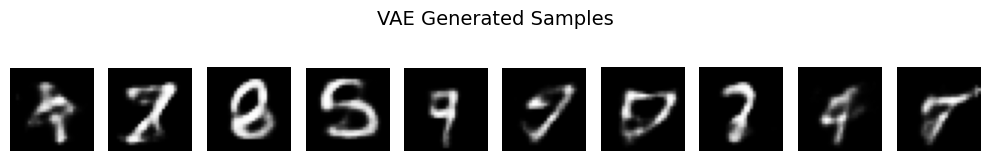

In [ ]:
import matplotlib.pyplot as plt

@torch.no_grad()
def show_vae_samples(n=10):
    vae.eval()

    # Âõ∫ÂÆöÈö®Ê©üÂô™ËÅ≤ z
    z = torch.randn(n, vae.z_dim).to(device)

    # Ëß£Á¢ºÊàêÂΩ±ÂÉè
    samples = vae.decode(z).view(-1, 28, 28).cpu().numpy()

    fig, axes = plt.subplots(1, n, figsize=(n, 1.5))
    for i in range(n):
        axes[i].imshow(samples[i], cmap="gray")
        axes[i].axis("off")

    # ‚úÖ Ë®≠ÂÆöÂ§ßÊ®ôÈ°åÔºåÁΩÆ‰∏≠È°ØÁ§∫
    plt.suptitle("VAE Generated Samples", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()


show_vae_samples()

# Generative Adversarial Network (GAN) ÈÇèËºØÊµÅÁ®ã

---

## 1. ÂïèÈ°åËÉåÊôØ
- **Ê†∏ÂøÉÊ¶ÇÂøµ**ÔºöGAN ÊòØ‰∏ÄÁ®Æ„ÄåÂ∞çÊäóÂºèÂ≠∏Áøí„ÄçÊ®°ÂûãÔºåÂåÖÂê´ÂÖ©ÂÄãÁ∂≤Ë∑ØÔºö
  - **ÁîüÊàêÂô® (Generator, G)**ÔºöÂæûÈö®Ê©üÂô™ËÅ≤‰∏≠ÁîüÊàêÂÅáÊ®£Êú¨„ÄÇ
  - **ÈëëÂà•Âô® (Discriminator, D)**ÔºöÂà§Êñ∑Ëº∏ÂÖ•Ê®£Êú¨ÊòØÁúüÁöÑ (‰æÜËá™Ë≥áÊñôÈõÜ) ÈÇÑÊòØÂÅáÁöÑ (‰æÜËá™ G)„ÄÇ
- **Ë®ìÁ∑¥ÈÅéÁ®ã**Ôºö  
  - G ÂòóË©¶È®ôÈÅé D ‚Üí ÁîüÊàêÁúãËµ∑‰æÜÊõ¥ÈÄºÁúüÁöÑÂÅáË≥áÊñô„ÄÇ  
  - D ÂòóË©¶ÂàÜËæ®ÁúüÂÅΩ ‚Üí ËÆìËá™Â∑±Âà§Êñ∑Êõ¥Ê∫ñÁ¢∫„ÄÇ  
- **ÊúÄÂæåÈÅîÊàê**Ôºö**Á¥çË®±ÂùáË°° (Nash equilibrium)** ‚Üí G ÁîüÊàêÁöÑÊ®£Êú¨Âπæ‰πéÂíåÁúüÂØ¶Ë≥áÊñôÂàÜÂ∏É‰∏ÄÊ®£ÔºåD ÂàÜ‰∏çÂá∫Â∑ÆÂà•„ÄÇ

---

## 2. Ë≥áÊñôÊµÅËàáÁ∂≠Â∫¶ (‰ª• MNIST 28√ó28 ÁÇ∫‰æã)

### ÁîüÊàêÂô® G
- Ëº∏ÂÖ•ÔºöÈö®Ê©üÂêëÈáè $z \sim \mathcal{N}(0,I)$ÔºåÂΩ¢ÁãÄ $(B, z\_dim, 1, 1)$  
- **Â±§Á¥öÁµêÊßãÔºö**
  - **Á¨¨‰∏ÄÂ±§ ConvTranspose2d**
    ```python
    nn.ConvTranspose2d(z_dim, 128, kernel_size=7, stride=1, padding=0)
    ```
    - Ëº∏ÂÖ•Â§ßÂ∞èÔºö$(B, z\_dim, 1, 1)$
    - Ë®àÁÆóÂÖ¨ÂºèÔºö
      $$
      H_{out} = (H_{in} - 1) \times stride - 2 \times padding + kernel\_size
      $$
      ‰ª£ÂÖ•Ôºö$H_{in}=1,\ stride=1,\ padding=0,\ kernel=7$
      $$
      H_{out} = (1-1)\times 1 - 0 + 7 = 7
      $$
    - Ëº∏Âá∫Â§ßÂ∞èÔºö$(B,128,7,7)$
  - **Á¨¨‰∫åÂ±§ ConvTranspose2d**
    ```python
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
    ```
    - Ëº∏ÂÖ•Â§ßÂ∞èÔºö$(B,128,7,7)$
    - ‰ª£ÂÖ•ÂÖ¨ÂºèÔºö$H_{in}=7,\ stride=2,\ padding=1,\ kernel=4$
      $$
      H_{out} = (7-1)\times 2 - 2 + 4 = 14
      $$
    - Ëº∏Âá∫Â§ßÂ∞èÔºö$(B,64,14,14)$
  - **Á¨¨‰∏âÂ±§ ConvTranspose2d**
    ```python
    nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1)
    ```
    - Ëº∏ÂÖ•Â§ßÂ∞èÔºö$(B,64,14,14)$
    - ‰ª£ÂÖ•ÂÖ¨ÂºèÔºö$H_{in}=14,\ stride=2,\ padding=1,\ kernel=4$
      $$
      H_{out} = (14-1)\times 2 - 2 + 4 = 28
      $$
    - Ëº∏Âá∫Â§ßÂ∞èÔºö$(B,1,28,28)$
- **ÊúÄÂæåËº∏Âá∫ÊøÄÊ¥ª**Ôºö
  - **Tanh** ‚Üí ÁØÑÂúç $[-1,1]$ÔºàÂ∏∏Áî®Êñº DCGANÔºâ
  - **Sigmoid** ‚Üí ÁØÑÂúç $[0,1]$ÔºàËã•Ëº∏ÂÖ•Ë≥áÊñôÊòØÊ≠∏‰∏ÄÂåñÂà∞ [0,1]Ôºâ

---

### ÈëëÂà•Âô® D
- Ëº∏ÂÖ•ÔºöÂΩ±ÂÉè $(B,1,28,28)$
- **Â±§Á¥öÁµêÊßãÔºö**
  - **Á¨¨‰∏ÄÂ±§ Conv2d**
    ```python
    nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)
    ```
    - Ëº∏ÂÖ•Â§ßÂ∞èÔºö$(B,1,28,28)$
    - Ë®àÁÆóÂÖ¨ÂºèÔºö
      $$
      H_{out} = \frac{H_{in} + 2\times padding - kernel\_size}{stride} + 1
      $$
      ‰ª£ÂÖ•Ôºö$H_{in}=28,\ stride=2,\ padding=1,\ kernel=4$
      $$
      H_{out} = \frac{28+2-4}{2}+1 = 14
      $$
    - Ëº∏Âá∫Â§ßÂ∞èÔºö$(B,64,14,14)$
  - **Á¨¨‰∫åÂ±§ Conv2d**
    ```python
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
    ```
    - Ëº∏ÂÖ•Â§ßÂ∞èÔºö$(B,64,14,14)$
    - ‰ª£ÂÖ•Ôºö$H_{in}=14,\ stride=2,\ padding=1,\ kernel=4$
      $$
      H_{out} = \frac{14+2-4}{2}+1 = 7
      $$
    - Ëº∏Âá∫Â§ßÂ∞èÔºö$(B,128,7,7)$
  - **Á¨¨‰∏âÂ±§ Conv2d**
    ```python
    nn.Conv2d(128, 1, kernel_size=7, stride=1, padding=0)
    ```
    - Ëº∏ÂÖ•Â§ßÂ∞èÔºö$(B,128,7,7)$
    - ‰ª£ÂÖ•Ôºö$H_{in}=7,\ stride=1,\ padding=0,\ kernel=7$
      $$
      H_{out} = \frac{7+0-7}{1}+1 = 1
      $$
    - Ëº∏Âá∫Â§ßÂ∞èÔºö$(B,1,1,1)$ ‚Üí ÂÜçÂ£ìÂπ≥Êàê $(B,1)$
- **ÊúÄÂæåËº∏Âá∫ÊøÄÊ¥ª**Ôºö
  - **Sigmoid**ÔºåÁµêÊûú $\in [0,1]$Ôºå‰ª£Ë°®„ÄåÁúüÂØ¶ÁöÑÊ©üÁéá„Äç„ÄÇ

---

## 3. ÊêçÂ§±ÂáΩÊï∏ (Â∞çÊäóÂºèÁõÆÊ®ô)

### Â∞çÈëëÂà•Âô® D
- Â∏åÊúõÂ∞çÁúüÂØ¶Ê®£Êú¨Ëº∏Âá∫ 1„ÄÅÂ∞çÂÅáÊ®£Êú¨Ëº∏Âá∫ 0„ÄÇ
- ÊêçÂ§±Ôºö
  $$
  L_D = -\frac{1}{2} \Big[ \log D(x_{real}) + \log (1 - D(x_{fake})) \Big]
  $$

### Â∞çÁîüÊàêÂô® G
- Â∏åÊúõÁîüÊàêÁöÑÂÅáÊ®£Êú¨ËÉΩÈ®ôÈÅé DÔºåË¢´Âà§Êñ∑ÁÇ∫Áúü„ÄÇ
- ÊêçÂ§±Ôºö
  $$
  L_G = - \log D(x_{fake})
  $$

---

## 4. Ë®ìÁ∑¥Ê≠•È©üÔºàÊØèÂÄã batchÔºâ
- **Ë®ìÁ∑¥ D**
  - ÂæûË≥áÊñôÈõÜ‰∏≠Âèñ‰∏ÄÊâπÁúüÊ®£Êú¨ÔºåÊ®ôÁ±§Ë®≠ÁÇ∫ 1„ÄÇ
  - Áî® G ÁîüÊàê‰∏ÄÊâπÂÅáÊ®£Êú¨ÔºåÊ®ôÁ±§Ë®≠ÁÇ∫ 0„ÄÇ
  - Áî® BCE Loss ÂàÜÂà•Ë®àÁÆóË™§Â∑ÆÔºåÊõ¥Êñ∞ D ÁöÑÂèÉÊï∏„ÄÇ
- **Ë®ìÁ∑¥ G**
  - ÈáçÊñ∞Âèñ‰∏ÄÊâπÂô™ËÅ≤ $z$ÔºåÁîüÊàêÂÅáÊ®£Êú¨„ÄÇ
  - È§µÈÄ≤ DÔºåÊúüÊúõ D ÁöÑËº∏Âá∫Êé•Ëøë 1 (Ë¢´È®ô)„ÄÇ
  - Áî® BCE Loss Êõ¥Êñ∞ G ÁöÑÂèÉÊï∏„ÄÇ

---

## 5. Á®ãÂºèÁ¢ºÂ∞çÊáâ (Ê†∏ÂøÉÂ∞çÁÖß)
- Generator È°ûÂà• ‚Üí ÂÆöÁæ©ÂèçÊç≤Á©çÁµêÊßãÔºåÊää $z$ ËÆäÊàê 28√ó28 ÂΩ±ÂÉè„ÄÇ
- Discriminator È°ûÂà• ‚Üí ÂÆöÁæ©Âç∑Á©çÁµêÊßãÔºåËº∏ÂÖ•ÂΩ±ÂÉèËº∏Âá∫ÁúüÂÅΩÊ©üÁéá„ÄÇ
- optG / optD ‚Üí ÂàÜÂà•Êõ¥Êñ∞ G Âíå D ÁöÑÊúÄ‰Ω≥ÂåñÂô® (Adam)„ÄÇ
- criterionÔºö
  - `nn.BCELoss()` ‚Üí ÈúÄË¶Å D Ëº∏Âá∫Á∂ìÈÅé **Sigmoid**ÔºàÁØÑÂúç [0,1]Ôºâ„ÄÇ
  - `nn.BCEWithLogitsLoss()` ‚Üí D Ëº∏Âá∫ raw logitÔºå‰∏çÈúÄÈ°ØÂºèÂä† SigmoidÔºåÊõ¥Á©©ÂÆö„ÄÇ
- Ë®ìÁ∑¥ÊµÅÁ®ãÔºö
  - `lossD_real = criterion(D(x_real), label_real)`
  - `lossD_fake = criterion(D(x_fake.detach()), label_fake)`
  - `lossG = criterion(D(x_fake), label_real)`

---

## 6. Ë®ìÁ∑¥ËßÄÂØü
- **LossD**
  - Â§™‰Ωé ‚Üí D Âà§Êñ∑Â§™Ê∫ñÔºåG ÂæàÈõ£Â≠∏„ÄÇ
  - Â§™È´ò ‚Üí D Ë¢´È®ôÂæóÂ§™ÊÖòÔºåÂèØËÉΩ G collapse„ÄÇ
- **LossG**
  - Â§™È´ò ‚Üí G ÁÑ°Ê≥ïÈ®ôÈÅé DÔºåÁîüÊàê‰∏çÁúüÂØ¶„ÄÇ
  - ÈÅ©‰∏≠ ‚Üí G Âíå D ÊãâÈã∏Ôºå‰ª£Ë°®Â∞çÊäóÂÅ•Â∫∑„ÄÇ
- **Â∏∏Ë¶ãÊäÄÂ∑ß**
  - Label smoothingÔºöÁúüÊ®£Êú¨Ê®ôÁ±§Áî± 1 ÊîπÊàê 0.9ÔºàÊàñÈö®Ê©üÂú® [0.8,1.0]ÔºâÔºåÈÅøÂÖç D ÈÅéÊñºÂº∑Â§ß„ÄÇ
  - BCEWithLogitsLossÔºöÂª∫Ë≠∞Âèñ‰ª£ BCELossÔºåÊï∏ÂÄºÊõ¥Á©©ÂÆö„ÄÇ
  - Âõ∫ÂÆö latent ÂêëÈáèÔºöÊØèÂÄã epoch Áî®Âêå‰∏ÄÁµÑ $z$ÔºåËº∏Âá∫ÂúñÁâáÊñπ‰æøËßÄÂØü G ÁöÑÂ≠∏ÁøíÊÉÖÊ≥Å„ÄÇ

---

## 7. Êï¥È´îÈÇèËºØÊëòË¶Å
- Generator (G)ÔºöÂô™ËÅ≤ ‚Üí ÂÅáÂúñÁâá„ÄÇ
- Discriminator (D)ÔºöÂúñÁâá ‚Üí ÁúüÊàñÂÅá„ÄÇ
- Â∞çÊäóÂºèË®ìÁ∑¥Ôºö
  - D Â≠∏ÊúÉÂà§Êñ∑ÁúüÂÅá„ÄÇ
  - G Â≠∏ÊúÉÈ®ôÈÅé D„ÄÇ
- ÊúÄÁµÇÁõÆÊ®ôÔºöÁîüÊàêÂô® G Áî¢ÁîüÁöÑÂΩ±ÂÉèÂíåÁúüÂØ¶Ë≥áÊñôÂàÜÂ∏ÉÂπæ‰πé‰∏ÄËá¥„ÄÇ


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image

# =============================
# 1. ÂÆöÁæ© GAN Ê®°Âûã
# =============================

class Generator(nn.Module):
    """
    ÁîüÊàêÂô® (G)ÔºöÂ∞áÈö®Ê©üÂô™ËÅ≤ z ËΩâÊèõÊàêÁúã‰ººÁúüÂØ¶ÁöÑÂúñÁâá„ÄÇ
    - ‰ΩøÁî® ConvTranspose2d (ÂèçÂç∑Á©ç/ËΩâÁΩÆÂç∑Á©ç) ÈÄêÊ≠•ÊîæÂ§ß z ÁöÑÁ©∫ÈñìÁ∂≠Â∫¶„ÄÇ
    - ÊúÄÂæåËº∏Âá∫‰∏ÄÂºµ 28x28 ÁöÑÁÅ∞ÈöéÂúñÁâá (MNIST)„ÄÇ
    """
    def __init__(self, z_dim=100, img_channels=1):
        super().__init__()

        self.z_dim = z_dim

        self.net = nn.Sequential(
            # Ëº∏ÂÖ• latent vector (B, z_dim, 1, 1) ‚Üí (B,128,7,7)
            # kernel=7, stride=1, padding=0
            nn.ConvTranspose2d(z_dim, 128, kernel_size=7, stride=1, padding=0, bias=False),
            # BatchNorm2dÔºöÊ®ôÊ∫ñÂåñÊØèÂÄã batch ÁöÑÁâπÂæµÂàÜÂ∏É ‚Üí Ë®ìÁ∑¥Êõ¥Á©©ÂÆöÔºåÂä†Âø´Êî∂ÊñÇ
            nn.BatchNorm2d(128),
            # ReLUÔºöÈùûÁ∑öÊÄßÊøÄÊ¥ªÔºåËÆìÁîüÊàêÂô®ËÉΩÂ≠∏ÁøíË§áÈõúÊò†Â∞ÑÔºåÊääÂô™ËÅ≤ËΩâÊèõÊàêÂΩ±ÂÉèÁâπÂæµ
            nn.ReLU(True),

            # (B,128,7,7) ‚Üí (B,64,14,14)
            # kernel=4, stride=2, padding=1
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # (B,64,14,14) ‚Üí (B,1,28,28)
            # Ëº∏Âá∫Ëàá MNIST ÂúñÁâáÂ§ßÂ∞èÁõ∏Âêå
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            # Â∞áÂÉèÁ¥†Â£ìÂà∞ [0,1]ÔºàÂõ†ÁÇ∫ MNIST ÊòØ [0,1]ÔºâÔºåÂ¶ÇÊûúËº∏ÂÖ•Ë≥áÊñôÊòØ [-1,1]ÔºåÊúÉÊîπÊàê Tanh()
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.net(z)


class Discriminator(nn.Module):
    """
    ÈëëÂà•Âô® (D)ÔºöÂà§Êñ∑Ëº∏ÂÖ•ÂúñÁâáÊòØÁúü (1) ÈÇÑÊòØÂÅá (0)„ÄÇ
    - ‰ΩøÁî® Conv2d (Âç∑Á©ç) ÈÄêÊ≠•Â£ìÁ∏ÆÂúñÁâáÁ©∫ÈñìÁ∂≠Â∫¶„ÄÇ
    - ÊúÄÂæåËº∏Âá∫‰∏ÄÂÄãÊ®ôÈáèÔºå‰ª£Ë°®„ÄåÁúüÂØ¶Ê©üÁéá„Äç„ÄÇ
    """
    def __init__(self, img_channels=1):
        super().__init__()

        self.net = nn.Sequential(
            # (B,1,28,28) ‚Üí (B,64,14,14)
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            # LeakyReLUÔºöÂÖÅË®± x<0 ÊôÇ‰ªçÊúâÂæÆÂ∞èÊ¢ØÂ∫¶ÔºåÈÅøÂÖç ReLU„ÄåÊ≠ªÊéâ„ÄçÔºåÊõ¥ÈÅ©ÂêàÂà§Âà•Âô®
            nn.LeakyReLU(0.2, inplace=True),

            # (B,64,14,14) ‚Üí (B,128,7,7)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            # BatchNorm2dÔºöÈÅøÂÖçÈëëÂà•Âô®Âõ†Ëº∏ÂÖ•Â∑ÆÁï∞Â§™Â§ßËÄå‰∏çÁ©©
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # (B,128,7,7) ‚Üí (B,1,1,1)
            nn.Conv2d(128, 1, kernel_size=7, stride=1, padding=0, bias=False),
            # Ëº∏Âá∫ ‚àà [0,1]Ôºå‰ª£Ë°®„ÄåÁúüÂØ¶Ê©üÁéá„Äç
            nn.Sigmoid()
        )

    def forward(self, x):
        # Â£ìÂπ≥Êàê (B,) ÂêëÈáèÔºåÊØèÂºµÂúñËº∏Âá∫‰∏ÄÂÄãÊï∏Â≠ó
        return self.net(x).view(-1)


# =============================
# 2. ÂàùÂßãÂåñÊ®°ÂûãËàáË®≠ÂÆö
# =============================

# z_dim latent ÂêëÈáèÁ∂≠Â∫¶ (Ëº∏ÂÖ•ÁîüÊàêÂô®ÁöÑÂô™ËÅ≤Â§ßÂ∞è)

# Âª∫Á´ã G Âíå D
G_1 = Generator(z_dim=100).to(device)
D_1 = Discriminator().to(device)

# AdamÔºöÂ∏∏Ë¶ã GAN ÊúÄ‰Ω≥ÂåñÂô® (beta Ë®≠ÁÇ∫ 0.5, 0.999 ÈÅøÂÖçÈúáÁõ™)
g_opt = optim.Adam(G_1.parameters(), lr=2e-4, betas=(0.5, 0.999))
d_opt = optim.Adam(D_1.parameters(), lr=2e-4, betas=(0.5, 0.999))

# ÊêçÂ§±ÂáΩÊï∏ÔºöBCE
criterion = nn.BCELoss()

os.makedirs("samples/gan", exist_ok=True)


# =============================
# 3. Ë®ìÁ∑¥ÊµÅÁ®ã
# =============================

def train_gan(epochs=5):
    # Âõ∫ÂÆöÂô™ËÅ≤ÔºåÁî®ÊñºÊØèÂÄã epoch ÁöÑËßÄÂØüÂúñ
    fixed_z = torch.randn(10, G_1.z_dim, 1, 1, device=device)

    for epoch in range(1, epochs + 1):
        # Âõ†ÁÇ∫Êúâ BatchNorm ‚Üí ÊØèÂÄã epoch ÈÉΩË¶ÅÈáçË®≠„ÄÇ
        G_1.train()
        D_1.train()

        total_d_loss, total_g_loss = 0.0, 0.0

        for x, _ in train_loader:
            x = x.to(device)  # (B,1,28,28)

            current_batch_size = x.size(0)
            real_labels = torch.ones(current_batch_size, device=device)   # ÁúüÂØ¶Ê®£Êú¨Ê®ôÁ±§=1
            fake_labels = torch.zeros(current_batch_size, device=device)  # ÂÅáÊ®£Êú¨Ê®ôÁ±§=0

            # --------- Ë®ìÁ∑¥ D ---------
            # step1: ÁúüÂØ¶Ê®£Êú¨
            d_loss_real = criterion(D_1(x), real_labels)

            # step2: ÂÅáÊ®£Êú¨ (Áî± G ÁîüÊàêÔºådetach ‰ª•ÂÖçÊõ¥Êñ∞ G)
            z = torch.randn(current_batch_size, G_1.z_dim, 1, 1, device=device)
            fake = G_1(z)
            d_loss_fake = criterion(D_1(fake.detach()), fake_labels)

            # D ÁöÑÁ∏ΩÊêçÂ§± = ÁúüÂØ¶ + ÂÅá ÁöÑÂπ≥Âùá
            d_loss = (d_loss_real + d_loss_fake) / 2

            # ÂÖ∏ÂûãË®ìÁ∑¥‰∏âÊ≠•È©üÔºöÊ∏ÖÊ¢ØÂ∫¶ ‚Üí ÂèçÂÇ≥ ‚Üí Êõ¥Êñ∞
            d_opt.zero_grad()
            d_loss.backward()
            d_opt.step()

            # --------- Ë®ìÁ∑¥ G ---------
            # Â∏åÊúõ D(fake)=1 (È®ôÈÅéÈëëÂà•Âô®)
            z = torch.randn(current_batch_size, G_1.z_dim, 1, 1, device=device)
            fake = G_1(z)
            g_loss = criterion(D_1(fake), real_labels)

            # ÂÖ∏ÂûãË®ìÁ∑¥‰∏âÊ≠•È©üÔºöÊ∏ÖÊ¢ØÂ∫¶ ‚Üí ÂèçÂÇ≥ ‚Üí Êõ¥Êñ∞
            g_opt.zero_grad()
            g_loss.backward()
            g_opt.step()

            # Á¥ØÂä†ÊêçÂ§±
            total_d_loss += d_loss.item() * current_batch_size
            total_g_loss += g_loss.item() * current_batch_size

        # Ë®àÁÆóÂπ≥ÂùáÊêçÂ§±
        d_avg = total_d_loss / len(train_loader.dataset)
        g_avg = total_g_loss / len(train_loader.dataset)

        print(f"[GAN] Epoch {epoch}, LossD={d_avg:.4f} | LossG={g_avg:.4f}")

        # ÊØèÂÄã epoch ÂÑ≤Â≠òÁîüÊàêÂúñÁâá
        save_gan_samples(epoch, fixed_z)


# =============================
# 4. ÂÑ≤Â≠òÁîüÊàêÊ®£Êú¨
# =============================

@torch.no_grad()
def save_gan_samples(epoch, fixed_z):
    # Ë©ï‰º∞Ê®°ÂºèÔºàÈóúÈñâ dropout Á≠âÔºâÔºåËàá no_grad() ‰∏ÄËµ∑ËÆìÊé®Ë´ñÊõ¥Âø´
    G_1.eval()

    fake = G_1(fixed_z).cpu()

    save_image(fake, f"samples/gan/epoch_{epoch}.png", nrow=10, normalize=True, value_range=(0, 1))

    print(f"Â∑≤ÂÑ≤Â≠ò samples/gan/epoch_{epoch}.png")


# =============================
# 5. Âü∑Ë°åË®ìÁ∑¥
# =============================

if __name__ == "__main__":
    train_gan(epochs=EPOCHS)
    print("GAN Ë®ìÁ∑¥ÂÆåÊàêÔºÅ")


[GAN] Epoch 1, LossD=0.3592 | LossG=1.6083
Â∑≤ÂÑ≤Â≠ò samples/gan/epoch_1.png
[GAN] Epoch 2, LossD=0.4262 | LossG=1.3289
Â∑≤ÂÑ≤Â≠ò samples/gan/epoch_2.png
[GAN] Epoch 3, LossD=0.4544 | LossG=1.2529
Â∑≤ÂÑ≤Â≠ò samples/gan/epoch_3.png
[GAN] Epoch 4, LossD=0.4664 | LossG=1.2385
Â∑≤ÂÑ≤Â≠ò samples/gan/epoch_4.png
[GAN] Epoch 5, LossD=0.4700 | LossG=1.2424
Â∑≤ÂÑ≤Â≠ò samples/gan/epoch_5.png
[GAN] Epoch 6, LossD=0.4811 | LossG=1.2364
Â∑≤ÂÑ≤Â≠ò samples/gan/epoch_6.png
[GAN] Epoch 7, LossD=0.4872 | LossG=1.2252
Â∑≤ÂÑ≤Â≠ò samples/gan/epoch_7.png
[GAN] Epoch 8, LossD=0.4939 | LossG=1.2168
Â∑≤ÂÑ≤Â≠ò samples/gan/epoch_8.png
[GAN] Epoch 9, LossD=0.5001 | LossG=1.2098
Â∑≤ÂÑ≤Â≠ò samples/gan/epoch_9.png
[GAN] Epoch 10, LossD=0.5002 | LossG=1.2110
Â∑≤ÂÑ≤Â≠ò samples/gan/epoch_10.png
[GAN] Epoch 11, LossD=0.5010 | LossG=1.2069
Â∑≤ÂÑ≤Â≠ò samples/gan/epoch_11.png
[GAN] Epoch 12, LossD=0.5007 | LossG=1.2223
Â∑≤ÂÑ≤Â≠ò samples/gan/epoch_12.png
[GAN] Epoch 13, LossD=0.5001 | LossG=1.2331
Â∑≤ÂÑ≤Â≠ò samples/gan/epoc

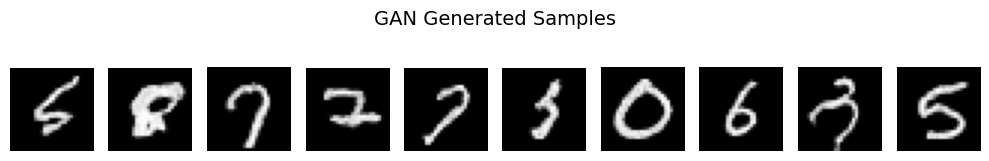

In [ ]:
import matplotlib.pyplot as plt

@torch.no_grad()
def show_gan_samples(n=10):
    G_1.eval()

    z = torch.randn(n, G_1.z_dim, 1, 1, device=device)

    fake_imgs = G_1(z).cpu().numpy()  # (10,1,28,28)

    fig, axes = plt.subplots(1, n, figsize=(n, 1.5))
    for i in range(n):
        axes[i].imshow(fake_imgs[i, 0], cmap="gray")
        axes[i].axis("off")

    # ‚úÖ Ë®≠ÂÆöÂ§ßÊ®ôÈ°åÔºåÁΩÆ‰∏≠È°ØÁ§∫
    plt.suptitle("GAN Generated Samples", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

show_gan_samples()

# Conditional Generative Adversarial Network (cGAN) ÈÇèËºØÊµÅÁ®ã

---

## 1. ÂïèÈ°åËÉåÊôØ
- **Ê†∏ÂøÉÊ¶ÇÂøµ**ÔºöcGAN Âú® GAN ÁöÑÂü∫Á§é‰∏ä **Âä†ÂÖ•Ê¢ù‰ª∂ (condition)**Ôºå‰æãÂ¶ÇÈ°ûÂà•Ê®ôÁ±§ÊàñÂ±¨ÊÄß„ÄÇ  
  - **ÁîüÊàêÂô® (Generator, G)**Ôºö‰∏çÂÉÖ‰æùÈù†Èö®Ê©üÂô™ËÅ≤ $z$ÔºåÈÇÑÊúÉËº∏ÂÖ•Ê¢ù‰ª∂ $y$ÔºàÂ¶ÇÊï∏Â≠ó 0‚Äì9 ÁöÑ one-hot ÂêëÈáèÔºâÔºåÁîüÊàêÂ∞çÊáâÁöÑÂÅáÊ®£Êú¨„ÄÇ  
  - **ÈëëÂà•Âô® (Discriminator, D)**ÔºöÈô§‰∫ÜËº∏ÂÖ•ÂΩ±ÂÉè $x$Ôºå‰πüÊúÉÊé•Êî∂Ê¢ù‰ª∂ $y$ÔºåÂà§Êñ∑Ê®£Êú¨ÊòØÂê¶„ÄåÂú®Ê¢ù‰ª∂ $y$ ‰∏ãÊòØÁúüÂØ¶ÁöÑ„Äç„ÄÇ  
- **ÊïàÊûú**ÔºöÂèØ‰ª•ÊéßÂà∂ÁîüÊàêÁöÑÂΩ±ÂÉèÂÖßÂÆπÔºå‰æãÂ¶ÇÊåáÂÆöË¶ÅÁîüÊàêÊâãÂØ´Êï∏Â≠ó ‚Äú7‚Äù„ÄÇ

---

## 2. Ë≥áÊñôÊµÅËàáÁ∂≠Â∫¶ (‰ª• MNIST 28√ó28 ÁÇ∫‰æã)

### ÁîüÊàêÂô® G
- Ëº∏ÂÖ•Ôºö
  - Èö®Ê©üÂêëÈáè $z \sim \mathcal{N}(0,I)$ÔºåÂΩ¢ÁãÄ $(B, z\_dim, 1, 1)$  
  - Ê¢ù‰ª∂ÂêëÈáè $y$Ôºå‰æãÂ¶ÇÊï∏Â≠ó 0‚Äì9 ÁöÑ one-hotÔºåÂΩ¢ÁãÄ $(B, num\_classes)$  
- **Êï¥ÂêàÊñπÂºèÔºö**
  - Â∏∏Ë¶ã‰ΩúÊ≥ïÔºöÊää $z$ Ëàá $y$ ÊãºÊé•Âæå‰∏ÄËµ∑Ëº∏ÂÖ•ÁîüÊàêÂô®„ÄÇ  
- **Ëº∏Âá∫**Ôºö
  - Ëàá GAN Áõ∏ÂêåÔºåÁ∂ìÈÅéÂèçÊç≤Á©çÂæóÂà∞ÂΩ±ÂÉè $(B,1,28,28)$  
  - Ëº∏Âá∫Á∂ì Tanh Êàñ SigmoidÔºàÂèñÊ±∫ÊñºË≥áÊñôÈ†êËôïÁêÜÁØÑÂúçÔºâ

### ÈëëÂà•Âô® D
- Ëº∏ÂÖ•Ôºö
  - ÂΩ±ÂÉè $x$ÔºàÁúüÊàñÂÅáÔºâ  
  - Ê¢ù‰ª∂ÂêëÈáè $y$  
- **Êï¥ÂêàÊñπÂºèÔºö**
  - Â∏∏Ë¶ãÊñπÊ≥ïÔºöÂ∞á $y$ Êì¥ÂºµÊàêËàá $x$ Áõ∏ÂêåÂ§ßÂ∞èÁöÑ feature mapÔºåËàáÂΩ±ÂÉèÂú® channel Á∂≠Â∫¶ÊãºÊé•„ÄÇ  
  - ‰æãÂ¶Ç $y$ ‚Üí $(B,num\_classes,28,28)$ÔºåËàá $x$ ÊãºÊé•Êàê $(B,1+num\_classes,28,28)$  
- **Ëº∏Âá∫**Ôºö
  - ÂñÆ‰∏ÄÊ©üÁéáÂÄº $\in [0,1]$Ôºå‰ª£Ë°®„ÄåÂú®Ê¢ù‰ª∂ $y$ ‰∏ãÔºåË©≤ÂΩ±ÂÉèÊòØÂê¶ÁúüÂØ¶„Äç„ÄÇ

---

## 3. ÊêçÂ§±ÂáΩÊï∏ (Â∞çÊäóÂºèÁõÆÊ®ô)

### Â∞çÈëëÂà•Âô® D
- Â∏åÊúõÂ∞ç„ÄåÁúüÊ®£Êú¨ + Ê¢ù‰ª∂ $y$„ÄçËº∏Âá∫ 1Ôºõ  
- Â∞ç„ÄåÂÅáÊ®£Êú¨ + Ê¢ù‰ª∂ $y$„ÄçËº∏Âá∫ 0„ÄÇ  
- ÊêçÂ§±Ôºö
  $$
  L_D = -\frac{1}{2}\Big[ \log D(x_{real}, y) + \log(1 - D(x_{fake}, y)) \Big]
  $$

### Â∞çÁîüÊàêÂô® G
- Â∏åÊúõ„ÄåÂÅáÊ®£Êú¨ + Ê¢ù‰ª∂ $y$„ÄçËÉΩÈ®ôÈÅé D ‚Üí Ëº∏Âá∫Êé•Ëøë 1„ÄÇ  
- ÊêçÂ§±Ôºö
  $$
  L_G = - \log D(x_{fake}, y)
  $$

---

## 4. Ë®ìÁ∑¥Ê≠•È©üÔºàÊØèÂÄã batchÔºâ
- **Ë®ìÁ∑¥ D**
  - ÂæûË≥áÊñôÈõÜ‰∏≠Âèñ‰∏ÄÊâπÁúüÊ®£Êú¨ $x_{real}$ÔºåÂèäÂÖ∂Ê®ôÁ±§ $y$ÔºåÊ®ôÁ±§Ë®≠ÁÇ∫ 1„ÄÇ  
  - Áî® G ÁîüÊàê‰∏ÄÊâπÂÅáÊ®£Êú¨ $x_{fake}$ÔºåÊê≠ÈÖçÁõ∏ÂêåÊ¢ù‰ª∂ $y$ÔºåÊ®ôÁ±§Ë®≠ÁÇ∫ 0„ÄÇ  
  - Áî® BCE Loss ÂàÜÂà•Ë®àÁÆóË™§Â∑ÆÔºåÊõ¥Êñ∞ D„ÄÇ  
- **Ë®ìÁ∑¥ G**
  - Âèñ‰∏ÄÊâπÈö®Ê©üÂô™ËÅ≤ $z$ ÂíåÊ¢ù‰ª∂ $y$ÔºåÁîüÊàêÂÅáÊ®£Êú¨ $x_{fake}$„ÄÇ  
  - È§µÈÄ≤ DÔºåÊúüÊúõ D ÁöÑËº∏Âá∫Êé•Ëøë 1„ÄÇ  
  - Áî® BCE Loss Êõ¥Êñ∞ G„ÄÇ  

---

## 5. Á®ãÂºèÁ¢ºÂ∞çÊáâ (Ê†∏ÂøÉÂ∞çÁÖß)
- **Generator È°ûÂà•** ‚Üí Êé•Êî∂ $(z,y)$ÔºåÁ∂ìÊãºÊé•ÂæåÁîüÊàêÂΩ±ÂÉè„ÄÇ  
- **Discriminator È°ûÂà•** ‚Üí Êé•Êî∂ $(x,y)$ÔºåÂú® channel Á∂≠Â∫¶ÊãºÊé•ÔºåËº∏Âá∫ÁúüÂÅΩÊ©üÁéá„ÄÇ  
- **optG / optD** ‚Üí Adam ÊúÄ‰Ω≥ÂåñÂô®ÔºåËàá GAN Áõ∏Âêå„ÄÇ  
- **criterion** ‚Üí
  - `nn.BCELoss()`ÔºàÈúÄ Sigmoid Ëº∏Âá∫Ôºâ  
  - Êàñ `nn.BCEWithLogitsLoss()`ÔºàÁõ¥Êé•Ëº∏Âá∫ logit Êõ¥Á©©ÂÆöÔºâ  
- **Ë®ìÁ∑¥ÊµÅÁ®ã**Ôºö
  - `lossD_real = criterion(D(x_real, y), label_real)`  
  - `lossD_fake = criterion(D(x_fake.detach(), y), label_fake)`  
  - `lossG = criterion(D(x_fake, y), label_real)`  

---

## 6. Ë®ìÁ∑¥ËßÄÂØü
- **LossD**
  - Â§™‰Ωé ‚Üí D Â§™Âº∑ÔºåG Â≠∏‰∏çÂà∞Êù±Ë•ø„ÄÇ  
  - Â§™È´ò ‚Üí D Â§™Âº±ÔºåG ËºïÊòìÈ®ôÈÅéÔºåÂèØËÉΩ collapse„ÄÇ  
- **LossG**
  - Â§™È´ò ‚Üí G ÁîüÊàê‰∏çÁúüÂØ¶„ÄÇ  
  - ÈÅ©‰∏≠ ‚Üí G Ëàá D ÊãâÈã∏ÔºåÂ∞çÊäóÂÅ•Â∫∑„ÄÇ  
- **Â∏∏Ë¶ãÊäÄÂ∑ß**
  - **Label smoothing**ÔºöÂ∞çÁúüÊ®£Êú¨Ê®ôÁ±§Áî® 0.9 Âèñ‰ª£ 1ÔºåÈÅøÂÖç D ÈÅéÂº∑„ÄÇ  
  - **Ê¢ù‰ª∂ÂµåÂÖ• (embedding)**ÔºöÂ∞á $y$ Á∂ìÂµåÂÖ•Â±§ÂæåÂÜçÊãºÊé•ÔºåËÉΩÊõ¥Á©©ÂÆöÂ≠∏Áøí„ÄÇ  
  - **Âõ∫ÂÆö latent ÂêëÈáè + Âõ∫ÂÆöÊ¢ù‰ª∂**ÔºöÊØèÂÄã epoch Áî®Âêå‰∏ÄÁµÑ $(z,y)$ÔºåÊñπ‰æøËßÄÂØü‰∏çÂêåÊ¢ù‰ª∂‰∏ãÁöÑÁîüÊàêÊïàÊûú„ÄÇ  

---

## 7. GAN vs cGAN Â∑ÆÁï∞Â∞çÁÖßË°®

| È†ÖÁõÆ | GAN | cGAN |
|------|-----|------|
| **Ëº∏ÂÖ• (G)** | Âô™ËÅ≤ÂêëÈáè $z$ | Âô™ËÅ≤ÂêëÈáè $z$ + Ê¢ù‰ª∂ $y$ |
| **Ëº∏ÂÖ• (D)** | ÂΩ±ÂÉè $x$ | ÂΩ±ÂÉè $x$ + Ê¢ù‰ª∂ $y$ |
| **ËÉΩÂê¶ÊéßÂà∂ÁîüÊàêÂÖßÂÆπ** | ‚ùå ÁÑ°Ê≥ïÊéßÂà∂ÔºåÈö®Ê©üÁîüÊàê | ‚úÖ ÂèØÊéßÔºå‰æùÊ¢ù‰ª∂ÁîüÊàêÁâπÂÆöÈ°ûÂà•ÊàñÁâπÂæµ |
| **ÊáâÁî®ÁØÑ‰æã** | ‰ªªÊÑèÂúñÂÉèÁîüÊàê | ÊâãÂØ´Êï∏Â≠óÂàÜÈ°ûÁîüÊàê„ÄÅ‰∫∫ËáâÂ±¨ÊÄßÁîüÊàê (Â¶ÇÊà¥ÁúºÈè°/‰∏çÊà¥ÁúºÈè°)„ÄÅÊñáÊú¨Âà∞ÂúñÂÉèÁîüÊàê |
| **ÊêçÂ§±ÂáΩÊï∏** | $\log D(x)$ Ëàá $\log (1-D(G(z)))$ | $\log D(x,y)$ Ëàá $\log (1-D(G(z,y),y))$ |

---

## 8. Êï¥È´îÈÇèËºØÊëòË¶Å
- **GAN Ëàá cGAN ÁöÑ‰∏ªË¶ÅÂ∑ÆÁï∞**Âú®ÊñºÊòØÂê¶Âä†ÂÖ•Ê¢ù‰ª∂Ôºö  
  - GAN ‚Üí ÁÑ°Ê≥ïÊéßÂà∂ÁîüÊàêÁöÑÊ®£Êú¨ÂÖßÂÆπ„ÄÇ  
  - cGAN ‚Üí ÂèØ‰ª•‰æùÊìöÊ¢ù‰ª∂Á≤æÁ¢∫ÊéßÂà∂ÁîüÊàêÁöÑÊ®£Êú¨Á®ÆÈ°ûÊàñÂ±¨ÊÄß„ÄÇ  
- **ÊúÄÁµÇÁõÆÊ®ô**ÔºöÂú®Áµ¶ÂÆöÊ¢ù‰ª∂‰∏ãÔºåÁîüÊàêÂô®ËÉΩÁî¢ÁîüÁ¨¶ÂêàÊ¢ù‰ª∂ÁöÑÁúüÂØ¶Ê®£Êú¨ÔºåËÆìÈëëÂà•Âô®Èõ£‰ª•ÂçÄÂàÜ„ÄÇ


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image

# =============================
# 1. ÂÆöÁæ© cGAN Ê®°Âûã
# =============================

class Generator(nn.Module):
    """
    Ê¢ù‰ª∂ÁîüÊàêÂô® (cG)ÔºöËº∏ÂÖ• (z, y)ÔºåËº∏Âá∫Á¨¶ÂêàÊ¢ù‰ª∂ y ÁöÑÂúñÁâá„ÄÇ
    - z: Èö®Ê©üÂô™ËÅ≤ (B, z_dim, 1, 1)
    - y: Ê¢ù‰ª∂Ê®ôÁ±§ (B,) ‚Üí one-hot ‚Üí (B, num_classes)
    """
    def __init__(self, z_dim=100, num_classes=10, img_channels=1):
        super().__init__()

        self.z_dim = z_dim
        self.num_classes = num_classes

        # EmbeddingÔºöÂ∞á y ËΩâÊèõÊàê one-hot ÂêëÈáè
        self.label_emb = nn.Embedding(num_classes, num_classes)

        # Ëº∏ÂÖ•Á∂≠Â∫¶ = z_dim + num_classes
        self.net = nn.Sequential(
            # Ëº∏ÂÖ• latent vector (B, z_dim + num_classes, 1, 1) ‚Üí (B,128,7,7)
            # kernel=7, stride=1, padding=0
            nn.ConvTranspose2d(z_dim + num_classes, 128, kernel_size=7, stride=1, padding=0, bias=False),
            # BatchNorm2dÔºöÊ®ôÊ∫ñÂåñÊØèÂÄã batch ÁöÑÁâπÂæµÂàÜÂ∏É ‚Üí Ë®ìÁ∑¥Êõ¥Á©©ÂÆöÔºåÂä†Âø´Êî∂ÊñÇ
            nn.BatchNorm2d(128),
            # ReLUÔºöÈùûÁ∑öÊÄßÊøÄÊ¥ªÔºåËÆìÁîüÊàêÂô®ËÉΩÂ≠∏ÁøíË§áÈõúÊò†Â∞ÑÔºåÊääÂô™ËÅ≤ËΩâÊèõÊàêÂΩ±ÂÉèÁâπÂæµ
            nn.ReLU(True),

            # (B,128,7,7) ‚Üí (B,64,14,14)
            # kernel=4, stride=2, padding=1
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # (B,64,14,14) ‚Üí (B,1,28,28)
            # Ëº∏Âá∫Ëàá MNIST ÂúñÁâáÂ§ßÂ∞èÁõ∏Âêå
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            # Â∞áÂÉèÁ¥†Â£ìÂà∞ [0,1]ÔºàÂõ†ÁÇ∫ MNIST ÊòØ [0,1]ÔºâÔºåÂ¶ÇÊûúËº∏ÂÖ•Ë≥áÊñôÊòØ [-1,1]ÔºåÊúÉÊîπÊàê Tanh()
            nn.Sigmoid()
        )

    def forward(self, z, y):
        # y: (B,) ‚Üí one-hot ‚Üí (B, num_classes)
        y_onehot = self.label_emb(y)
        # ÊãºÊé•Ôºöz Âíå y Âú® channel Á∂≠Â∫¶Âêà‰Ωµ ‚Üí (B, z_dim + num_classes, 1, 1)
        z = torch.cat([z, y_onehot.unsqueeze(2).unsqueeze(3)], dim=1)

        return self.net(z)


class Discriminator(nn.Module):
    """
    Ê¢ù‰ª∂ÈëëÂà•Âô® (cD)ÔºöËº∏ÂÖ• (x, y)ÔºåÂà§Êñ∑ÂúñÂÉèÊòØÂê¶„ÄåÁúüÂØ¶‰∏îÁ¨¶ÂêàÊ¢ù‰ª∂ y„Äç„ÄÇ
    - x: Ëº∏ÂÖ•ÂΩ±ÂÉè (B,1,28,28)
    - y: Ê¢ù‰ª∂Ê®ôÁ±§ (B,)
    """
    def __init__(self, num_classes=10, img_channels=1):
        super().__init__()
        self.num_classes = num_classes

        # EmbeddingÔºöÂ∞á y ËΩâÊàê one-hot ‚Üí (B,num_classes)
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.net = nn.Sequential(
            # (B,1 + num_classes,28,28) ‚Üí (B,64,14,14)
            nn.Conv2d(img_channels + num_classes, 64, kernel_size=4, stride=2, padding=1, bias=False),
            # LeakyReLUÔºöÂÖÅË®± x<0 ÊôÇ‰ªçÊúâÂæÆÂ∞èÊ¢ØÂ∫¶ÔºåÈÅøÂÖç ReLU„ÄåÊ≠ªÊéâ„ÄçÔºåÊõ¥ÈÅ©ÂêàÂà§Âà•Âô®
            nn.LeakyReLU(0.2, inplace=True),

            # (B,64,14,14) ‚Üí (B,128,7,7)
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            # BatchNorm2dÔºöÈÅøÂÖçÈëëÂà•Âô®Âõ†Ëº∏ÂÖ•Â∑ÆÁï∞Â§™Â§ßËÄå‰∏çÁ©©
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # (B,128,7,7) ‚Üí (B,1,1,1)
            nn.Conv2d(128, 1, kernel_size=7, stride=1, padding=0, bias=False),
            # Ëº∏Âá∫ ‚àà [0,1]Ôºå‰ª£Ë°®„ÄåÁúüÂØ¶Ê©üÁéá„Äç
            nn.Sigmoid()
        )

    def forward(self, x, y):
        # y: (B,) ‚Üí one-hot ‚Üí (B,num_classes)
        y_onehot = self.label_emb(y)
        # Êì¥Â±ïÂà∞ÂΩ±ÂÉèÂ§ßÂ∞è (B,num_classes,28,28)
        y_map = y_onehot.unsqueeze(2).unsqueeze(3).expand(-1, -1, 28, 28)
        # ÊãºÊé•Âú® channel Á∂≠Â∫¶ ‚Üí (B,1 + num_classes,28,28)
        x = torch.cat([x, y_map], dim=1)

        # Â£ìÂπ≥Êàê (B,) ÂêëÈáèÔºåÊØèÂºµÂúñËº∏Âá∫‰∏ÄÂÄãÊï∏Â≠ó
        return self.net(x).view(-1)


# =============================
# 2. ÂàùÂßãÂåñÊ®°ÂûãËàáË®≠ÂÆö
# =============================

# MNIST 0~9ÔºåÂÖ± 10 È°û
num_classes = 10

# z_dim latent ÂêëÈáèÁ∂≠Â∫¶ (Ëº∏ÂÖ•ÁîüÊàêÂô®ÁöÑÂô™ËÅ≤Â§ßÂ∞è)
# Âª∫Á´ã G Âíå D
G_2 = Generator(z_dim=100, num_classes=num_classes).to(device)
D_2 = Discriminator(num_classes=num_classes).to(device)

# AdamÔºöÂ∏∏Ë¶ã GAN ÊúÄ‰Ω≥ÂåñÂô® (beta Ë®≠ÁÇ∫ 0.5, 0.999 ÈÅøÂÖçÈúáÁõ™)
g_opt = optim.Adam(G_2.parameters(), lr=2e-4, betas=(0.5, 0.999))
d_opt = optim.Adam(D_2.parameters(), lr=2e-4, betas=(0.5, 0.999))

# ÊêçÂ§±ÂáΩÊï∏ÔºöBCE
criterion = nn.BCELoss()

os.makedirs("samples/cgan", exist_ok=True)


# =============================
# 3. Ë®ìÁ∑¥ÊµÅÁ®ã
# =============================

def train_cgan(epochs=5):
    # Âõ∫ÂÆöÂô™ËÅ≤ & Ê®ôÁ±§ÔºåÁî®ÊñºÊØèÂÄã epoch ÁöÑËßÄÂØüÂúñ
    fixed_z = torch.randn(10, G_2.z_dim, 1, 1, device=device)
    fixed_y = torch.arange(0, 10, device=device)  # 0~9 ÂêÑÁîüÊàê‰∏ÄÂºµ

    for epoch in range(1, epochs + 1):
        # Âõ†ÁÇ∫Êúâ BatchNorm ‚Üí ÊØèÂÄã epoch ÈÉΩË¶ÅÈáçË®≠„ÄÇ
        G_2.train()
        D_2.train()

        total_d_loss, total_g_loss = 0.0, 0.0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            current_batch_size = x.size(0)
            real_labels = torch.ones(current_batch_size, device=device)   # ÁúüÂØ¶Ê®£Êú¨Ê®ôÁ±§=1
            fake_labels = torch.zeros(current_batch_size, device=device)  # ÂÅáÊ®£Êú¨Ê®ôÁ±§=0

            # --------- Ë®ìÁ∑¥ D ---------
            # step1: ÁúüÂØ¶Ê®£Êú¨ (x,y)
            d_loss_real = criterion(D_2(x, y), real_labels)

            # step2: ÂÅáÊ®£Êú¨ (Áî± G ÁîüÊàêÔºådetach ‰ª•ÂÖçÊõ¥Êñ∞ G)
            z = torch.randn(current_batch_size, G_2.z_dim, 1, 1, device=device)
            fake = G_2(z, y)
            d_loss_fake = criterion(D_2(fake.detach(), y), fake_labels)

            # D ÁöÑÁ∏ΩÊêçÂ§± = ÁúüÂØ¶ + ÂÅá ÁöÑÂπ≥Âùá
            d_loss = (d_loss_real + d_loss_fake) / 2

            # ÂÖ∏ÂûãË®ìÁ∑¥‰∏âÊ≠•È©üÔºöÊ∏ÖÊ¢ØÂ∫¶ ‚Üí ÂèçÂÇ≥ ‚Üí Êõ¥Êñ∞
            d_opt.zero_grad()
            d_loss.backward()
            d_opt.step()

            # --------- Ë®ìÁ∑¥ G ---------
            # Â∏åÊúõ D(fake,y)=1 (È®ôÈÅéÈëëÂà•Âô®)
            z = torch.randn(current_batch_size, G_2.z_dim, 1, 1, device=device)
            fake = G_2(z, y)
            g_loss = criterion(D_2(fake, y), real_labels)

            # ÂÖ∏ÂûãË®ìÁ∑¥‰∏âÊ≠•È©üÔºöÊ∏ÖÊ¢ØÂ∫¶ ‚Üí ÂèçÂÇ≥ ‚Üí Êõ¥Êñ∞
            g_opt.zero_grad()
            g_loss.backward()
            g_opt.step()

            # Á¥ØÂä†ÊêçÂ§±
            total_d_loss += d_loss.item() * current_batch_size
            total_g_loss += g_loss.item() * current_batch_size

        # Ë®àÁÆóÂπ≥ÂùáÊêçÂ§±
        d_avg = total_d_loss / len(train_loader.dataset)
        g_avg = total_g_loss / len(train_loader.dataset)

        print(f"[cGAN] Epoch {epoch}, LossD={d_avg:.4f} | LossG={g_avg:.4f}")

        save_cgan_samples(epoch, fixed_z, fixed_y)


# =============================
# 4. ÂÑ≤Â≠òÁîüÊàêÊ®£Êú¨
# =============================

@torch.no_grad()
def save_cgan_samples(epoch, fixed_z, fixed_y):
    # Ë©ï‰º∞Ê®°ÂºèÔºàÈóúÈñâ dropout Á≠âÔºâÔºåËàá no_grad() ‰∏ÄËµ∑ËÆìÊé®Ë´ñÊõ¥Âø´
    G_2.eval()

    fake = G_2(fixed_z, fixed_y).cpu()

    save_image(fake, f"samples/cgan/epoch_{epoch}.png", nrow=10, normalize=True, value_range=(0, 1))

    print(f"Â∑≤ÂÑ≤Â≠ò samples/cgan/epoch_{epoch}.png")


# =============================
# 5. Âü∑Ë°åË®ìÁ∑¥
# =============================

if __name__ == "__main__":
    train_cgan(epochs=EPOCHS)
    print("cGAN Ë®ìÁ∑¥ÂÆåÊàêÔºÅ")


[cGAN] Epoch 1, LossD=0.5734 | LossG=0.9805
Â∑≤ÂÑ≤Â≠ò samples/cgan/epoch_1.png
[cGAN] Epoch 2, LossD=0.6389 | LossG=0.8333
Â∑≤ÂÑ≤Â≠ò samples/cgan/epoch_2.png
[cGAN] Epoch 3, LossD=0.6493 | LossG=0.8114
Â∑≤ÂÑ≤Â≠ò samples/cgan/epoch_3.png
[cGAN] Epoch 4, LossD=0.6688 | LossG=0.7914
Â∑≤ÂÑ≤Â≠ò samples/cgan/epoch_4.png
[cGAN] Epoch 5, LossD=0.6767 | LossG=0.7721
Â∑≤ÂÑ≤Â≠ò samples/cgan/epoch_5.png
[cGAN] Epoch 6, LossD=0.6816 | LossG=0.7641
Â∑≤ÂÑ≤Â≠ò samples/cgan/epoch_6.png
[cGAN] Epoch 7, LossD=0.6837 | LossG=0.7538
Â∑≤ÂÑ≤Â≠ò samples/cgan/epoch_7.png
[cGAN] Epoch 8, LossD=0.6862 | LossG=0.7472
Â∑≤ÂÑ≤Â≠ò samples/cgan/epoch_8.png
[cGAN] Epoch 9, LossD=0.6874 | LossG=0.7527
Â∑≤ÂÑ≤Â≠ò samples/cgan/epoch_9.png
[cGAN] Epoch 10, LossD=0.6882 | LossG=0.7459
Â∑≤ÂÑ≤Â≠ò samples/cgan/epoch_10.png
[cGAN] Epoch 11, LossD=0.6892 | LossG=0.7400
Â∑≤ÂÑ≤Â≠ò samples/cgan/epoch_11.png
[cGAN] Epoch 12, LossD=0.6894 | LossG=0.7372
Â∑≤ÂÑ≤Â≠ò samples/cgan/epoch_12.png
[cGAN] Epoch 13, LossD=0.6901 | LossG=0.7372
Â

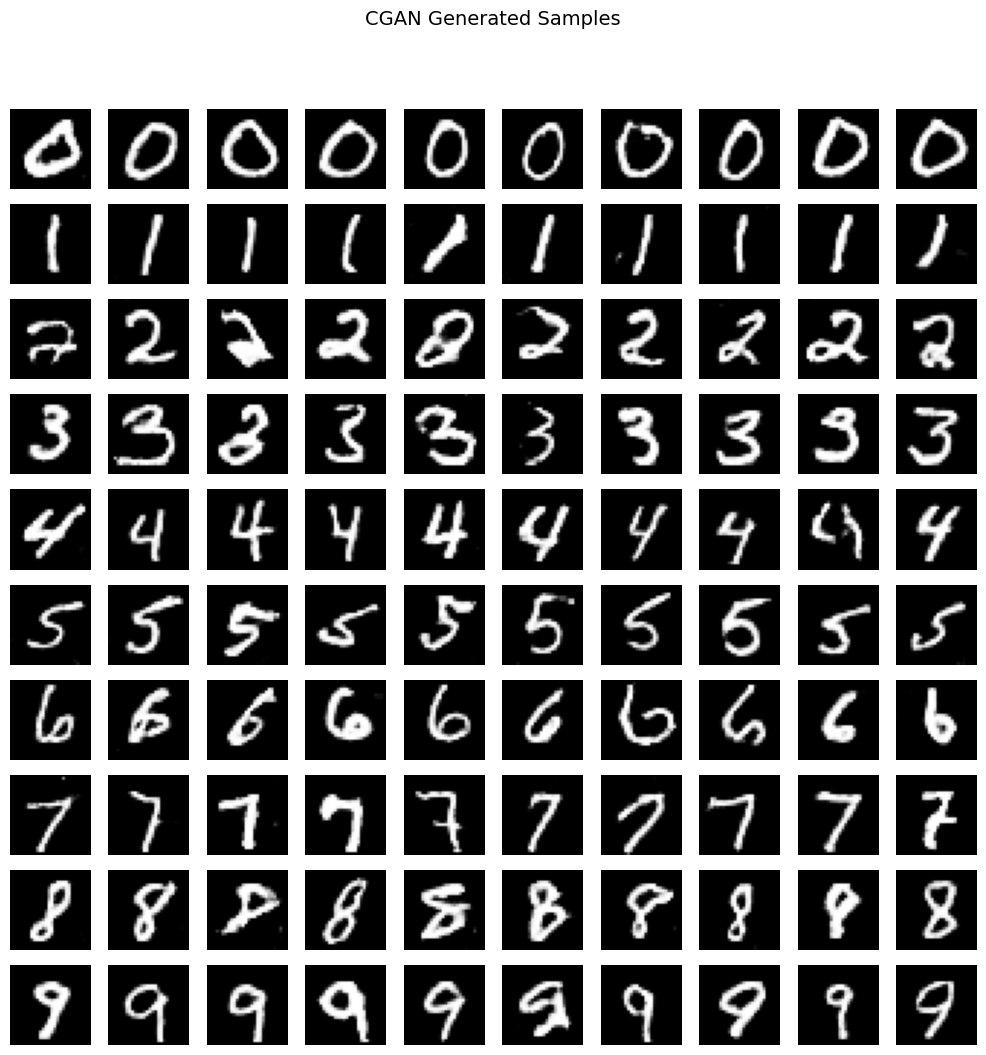

In [ ]:
import matplotlib.pyplot as plt

@torch.no_grad()
def show_cgan_samples(n=10):
    G_2.eval()

    # Âª∫Á´ã 10√ó10 ÁöÑ labelÔºöÊØè‰∏ÄÂàóÈÉΩÊòØÂêå‰∏ÄÂÄãÊï∏Â≠ó
    labels = torch.arange(0, n, device=device).repeat_interleave(n)

    # Èö®Ê©üÂô™ËÅ≤
    z = torch.randn(n * n, G_2.z_dim, 1, 1, device=device)

    # ÁîüÊàêÂΩ±ÂÉè (100,1,28,28)
    fake_imgs = G_2(z, labels).cpu().numpy()

    fig, axes = plt.subplots(n, n, figsize=(10, 10))
    idx = 0
    for i in range(n):
        for j in range(n):
            axes[i, j].imshow(fake_imgs[idx, 0], cmap="gray")
            axes[i, j].axis("off")
            idx += 1

    # ‚úÖ Ë®≠ÂÆöÂ§ßÊ®ôÈ°åÔºåÁΩÆ‰∏≠È°ØÁ§∫
    plt.suptitle("CGAN Generated Samples", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

show_cgan_samples()

# DDPM (Denoising Diffusion Probabilistic Model) with U-Net ÈÇèËºØÊµÅÁ®ã

---

## 1. ÂïèÈ°åËÉåÊôØ
- **Ê†∏ÂøÉÊ¶ÇÂøµ**ÔºöDDPM ÊòØ‰∏ÄÁ®ÆÁîüÊàêÊ®°ÂûãÔºåÈÄèÈÅé„ÄåÈÄêÊ≠•Âä†Âô™ ‚Üí Â≠∏ÁøíÂéªÂô™ ‚Üí ÈÄêÊ≠•ÂéªÂô™ÁîüÊàê„ÄçÁöÑÈÅéÁ®ãÔºåÂæûÁ¥îÈö®Ê©üÈ´òÊñØÂô™ËÅ≤ÈáçÂª∫Âá∫ÁúüÂØ¶ÂΩ±ÂÉè„ÄÇ  
- **ÊµÅÁ®ã**Ôºö
  1. **Forward Diffusion**ÔºöÂ∞çÂéüÂßãÂúñÁâá $x_0$ Âú® $T$ Ê≠•ÂÖßÈÄêÊ≠•Âä†Âô™ÔºåÂæóÂà∞ $x_t$ÔºåÊúÄÂæåË∂®ËøëÊñºÁ¥îÂô™ËÅ≤„ÄÇ  
  2. **Reverse Diffusion**ÔºöÁî®Ê®°ÂûãÂ≠∏ÁøíÊØè‰∏ÄÊ≠•ÁöÑÂéªÂô™ÔºåÂæû $x_T \sim \mathcal{N}(0,I)$ ÈÄêÊ≠•ÂõûÂà∞‰πæÊ∑®ÂΩ±ÂÉè $x_0$„ÄÇ  

---

## 2. ÊôÇÈñìÂµåÂÖ• (Sinusoidal Embedding)
- **ÂïèÈ°å**ÔºöÊ®°ÂûãÂè™ÁúãÂà∞ $x_t$Ôºå‰ΩÜ‰∏çÁü•ÈÅì„ÄåÈÄôÂºµÂúñÊòØÁ¨¨ÂπæÊ≠•„Äç„ÄÇ  
- **Ëß£Ê≥ï**ÔºöÊääÊï¥Êï∏ $t$ ËΩâÊàê‰∏ÄÂÄãÈ´òÁ∂≠ÂêëÈáè $t\_{emb}$ÔºåËÆìÁ∂≤Ë∑ØÊÑüÁü•„ÄåÂô™ËÅ≤Á®ãÂ∫¶„Äç„ÄÇ  
- **ÂÖ¨Âºè**ÔºàÁ∂≠Â∫¶ $d$ÔºâÔºö  
  $$
  \text{PE}(t,2i) = \sin\!\Big(\frac{t}{10000^{2i/d}}\Big), \quad
  \text{PE}(t,2i+1) = \cos\!\Big(\frac{t}{10000^{2i/d}}\Big)
  $$  
- **Áõ¥Ë¶∫**ÔºöÂ∞±ÂÉèÂú®ÊØè‰∏ÄÊ≠•Áµ¶Ê®°Âûã‰∏ÄÂºµ„ÄåÂô™ËÅ≤Á®ãÂ∫¶ÁöÑÂêçÁâá„Äç„ÄÇ

---

## 3. Âç∑Á©çÊ®°Â°ä (Residual / Down / Up Block)

### 3.1 ÂÖ±ÂêåÁµêÊßã
1. **Âç∑Á©ç + BN + ReLU** ÊèêÂèñÁâπÂæµ„ÄÇ  
2. **ÊôÇÈñìË™øËÆä**Ôºö  
   - Êää $t\_{emb}$ Á∂ì MLP ÊäïÂΩ±Âà∞ËàáÈÄöÈÅìÊï∏Áõ∏ÂêåÁöÑÁ∂≠Â∫¶„ÄÇ  
   - Âä†Âà∞ feature map ‰∏äÔºàbroadcast Âà∞Êï¥ÂºµÂúñÔºâÔºö  
     $$
     h = h + W_t(t\_{emb})[:, :, None, None]
     $$
3. **Âç∑Á©ç + BN + ReLU** ÂÜçËôïÁêÜ„ÄÇ  

üëâ ÈÄô‰∏ÄÊ≠•ËÆì„ÄåÊôÇÈñìË≥áË®ä„ÄçÈÄ≤ÂÖ•ÂΩ±ÂÉèÁâπÂæµÔºåÂëäË®¥Á∂≤Ë∑Ø„ÄåË¶ÅÂéªÂ§öÂ∞ëÂô™ËÅ≤„Äç„ÄÇ

### 3.2 Down Block
- ÊúÄÂæåÁî® **Conv2d(stride=2)**ÔºåËÆìÂ∞∫ÂØ∏Ê∏õÂçä„ÄÇ  
- **ÂÖ¨Âºè**Ôºö  
  $$
  H_{out} = \Big\lfloor \frac{H_{in}+2p-k}{s}\Big\rfloor + 1
  $$  
  ‰æãÂ¶Ç $k=4,s=2,p=1$ ‚Üí $28 \to 14$„ÄÇ  

### 3.3 Up Block
- ÊúÄÂæåÁî® **ConvTranspose2d(stride=2)**ÔºåËÆìÂ∞∫ÂØ∏ÁøªÂÄç„ÄÇ  
- **ÂÖ¨Âºè**Ôºö  
  $$
  H_{out} = (H_{in}-1)\cdot s - 2p + k
  $$  
  ‰æãÂ¶Ç $k=4,s=2,p=1$ ‚Üí $7 \to 14$„ÄÇ  

---

## 4. U-Net Backbone
- **Á∑®Á¢ºÂô® (Encoder)**ÔºöÈÄêÊ≠•‰∏ãÊé°Ê®£ ‚Üí ÊäΩË±°Âá∫Ë™ûÁæ©ÁâπÂæµ„ÄÇ  
- **‰∏≠ÈñìÂ±§ (Mid Block)**Ôºö‰øùÊåÅÂ∞∫ÂØ∏‰∏çËÆä ‚Üí Ê∑±Â∫¶ËôïÁêÜÊäΩË±°Ë™ûÁæ©„ÄÇ  
- **Ëß£Á¢ºÂô® (Decoder)**ÔºöÈÄêÊ≠•‰∏äÊé°Ê®£ ‚Üí ÈáçÂª∫ÂΩ±ÂÉèËß£ÊûêÂ∫¶„ÄÇ  
- **Skip Connection**ÔºöÂú®Â∞çÊáâËß£ÊûêÂ∫¶Êää Encoder ÁöÑÁâπÂæµÂä†Âõû‰æÜÔºå‰øùÁïôÁ¥∞ÁØÄ„ÄÇ  

üëâ Â∞±ÂÉè„ÄåÂÖàÂ£ìÁ∏Æ ‚Üí ËôïÁêÜ ‚Üí ÂÜçÈÇÑÂéü„ÄçÔºå‰∏¶‰∏îÂú®Ëß£Â£ìÊôÇÊääÁ¥∞ÁØÄË£úÂõû‰æÜ„ÄÇ

---

## 5. Forward Diffusion ÂÖ¨Âºè
Â∞çÊñº timestep $t$Ôºö  
$$
x_t = \sqrt{\bar{\alpha}_t}\,x_0 + \sqrt{1-\bar{\alpha}_t}\,\epsilon, \quad \epsilon \sim \mathcal{N}(0,I)
$$
ÂÖ∂‰∏≠Ôºö  
- $\beta_t$ÔºöÊØèÊ≠•Âä†ÁöÑÂô™ËÅ≤ÊØî‰æãÔºàÈÄöÂ∏∏Á∑öÊÄßÊéíÁ®ãÔºâ„ÄÇ  
- $\alpha_t = 1-\beta_t$„ÄÇ  
- $\bar{\alpha}_t = \prod_{s=1}^t \alpha_s$ÔºàÁ¥ØÁ©çÂô™ËÅ≤Âº∑Â∫¶Ôºâ„ÄÇ  

üëâ ÊàëÂÄëÂèØ‰ª•Áõ¥Êé•Âæû $x_0$ ‰∏ÄÊ≠•ÊäΩÊ®£Âà∞ $x_t$Ôºå‰∏çÁî®ÁúüÁöÑÂä†Âô™ $t$ Ê¨°„ÄÇ

---

## 6. Reverse Diffusion ÂÖ¨Âºè
Âú®ÁîüÊàêÊôÇÔºåÊØè‰∏ÄÊ≠•Ë¶ÅÂæû $x_t$ Êé®Âõû $x_{t-1}$Ôºö  
$$
x_{t-1} = \frac{1}{\sqrt{\alpha_t}}\Big(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}\,\epsilon_\theta(x_t,t)\Big) + \sigma_t z
$$
ÂÖ∂‰∏≠Ôºö  
- $\epsilon_\theta(x_t,t)$ÔºöÊ®°ÂûãÈ†êÊ∏¨Âô™ËÅ≤„ÄÇ  
- $\sigma_t = \sqrt{\beta_t}$„ÄÇ  
- $z \sim \mathcal{N}(0,I)$ÔºåÂè™Âú® $t>0$ ÊôÇÂä†ÂÖ• ‚Üí ‰øùÁïôÈö®Ê©üÊÄß„ÄÇ  

üëâ Â∞±ÂÉè„Äå‰∏ÄÊ≠•‰∏ÄÊ≠•Êì¶ÊéâÈõúË®äÔºåÊúÄÂæåÂæóÂà∞‰πæÊ∑®ÂúñÁâá„Äç„ÄÇ

---

## 7. ÊêçÂ§±ÂáΩÊï∏
Âõ†ÁÇ∫ÊàëÂÄëÁü•ÈÅì forward ÁöÑÁúüÂØ¶Âô™ËÅ≤ $\epsilon$ÔºåË®ìÁ∑¥ÁõÆÊ®ôÂ∞±ÊòØÔºö  
$$
\mathcal{L} = \mathbb{E}_{x_0,t,\epsilon}\big[\|\epsilon - \epsilon_\theta(x_t,t)\|^2\big]
$$
- ‰ΩøÁî® **MSE Loss**ÔºåÂº∑Ëø´Ê®°ÂûãÊ≠£Á¢∫È†êÊ∏¨Âô™ËÅ≤„ÄÇ

---

## 8. Ë®ìÁ∑¥ÊµÅÁ®ãÔºàÊØèÂÄã batchÔºâ
1. ÂæûË≥áÊñôÈõÜ‰∏≠Âèñ‰∏ÄÂºµÂΩ±ÂÉè $x_0$„ÄÇ  
2. Èö®Ê©üÈÅ∏ timestep $t$„ÄÇ  
3. Áî® forward ÂÖ¨ÂºèÂæóÂà∞ $x_t$ ÂíåÁúüÂØ¶Âô™ËÅ≤ $\epsilon$„ÄÇ  
4. Ê®°ÂûãËº∏ÂÖ• $(x_t,t)$ÔºåËº∏Âá∫ $\epsilon_\theta$„ÄÇ  
5. Ë®àÁÆó MSE LossÔºåÊõ¥Êñ∞ÂèÉÊï∏„ÄÇ  

---

## 9. Ë®ìÁ∑¥ËßÄÂØü
- **Loss Êõ≤Á∑ö**ÔºöÊáâË©≤Âπ≥Êªë‰∏ãÈôç„ÄÇ  
- **ÁîüÊàêÂΩ±ÂÉè**Ôºö  
  - ÂàùÊúü ‚Üí Ê®°Á≥äÊñëÂ°ä„ÄÇ  
  - ‰∏≠Êúü ‚Üí Âá∫ÁèæÊï∏Â≠óËº™Âªì„ÄÇ  
  - ÂæåÊúü ‚Üí Ê∏ÖÊô∞ÊâãÂØ´Êï∏Â≠ó„ÄÇ  
- **ÈóúÈçµÂèÉÊï∏**Ôºö  
  - $T=1000$ ‚Üí Ë∂äÂ§ßË∂äÁ≤æÁ¥∞Ôºå‰ΩÜÂèñÊ®£Êõ¥ÊÖ¢„ÄÇ  
  - Â≠∏ÁøíÁéá $lr=1e-4$ ‚Üí Â§™È´òÊúÉÁôºÊï£ÔºåÂ§™‰ΩéÊî∂ÊñÇÊÖ¢„ÄÇ  
  - ÈÄöÈÅìÊï∏ `64-128-256` ‚Üí Ê®°ÂûãË∂äÊ∑±Ë∂äÂØ¨ÔºåÊïàÊûúË∂äÂ•Ω„ÄÇ  

---

## 10. Á∏ΩÁµê
- **ÊôÇÈñìÂµåÂÖ•**ÔºöÊääÊ≠•Êï∏ $t$ Á∑®ÊàêÂêëÈáèÔºåÊèê‰æõ„ÄåÂô™ËÅ≤Á®ãÂ∫¶„ÄçË®äÊÅØ„ÄÇ  
- **Residual/Down/Up Block**ÔºöÂú®Âç∑Á©çÂ±§‰∏≠Ê≥®ÂÖ•ÊôÇÈñìË≥áË®äÔºå‰∏¶ÂÅö‰∏ä‰∏ãÊé°Ê®£„ÄÇ  
- **U-Net**ÔºöÁ∑®Á¢ºÂ£ìÁ∏Æ ‚Üí ‰∏≠ÈñìËôïÁêÜ ‚Üí Ëß£Á¢ºÈÇÑÂéüÔºåË∑≥Êé•‰øùÁ¥∞ÁØÄ„ÄÇ  
- **ÂÖ¨Âºè**Ôºö  
  - Forward ‚Üí Âä†Âô™„ÄÇ  
  - Reverse ‚Üí ÂéªÂô™„ÄÇ  
- **ÊúÄÁµÇÁõÆÊ®ô**ÔºöÂ≠∏ÊúÉ„ÄåÁúãÂúñË™™Âô™„ÄçÔºåÁî®ÈÄôÂÄãËÉΩÂäõÂæûÁ¥îÂô™ËÅ≤ÁîüÊàêÊ∏ÖÊô∞ÂΩ±ÂÉè„ÄÇ  


In [ ]:
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image


# =============================
# 1. Sinusoidal Timestep Embedding
# =============================

def sinusoidal_embedding(t, dim):
    """
    Êää timestep (0 ~ T-1) Á∑®Á¢ºÊàêÈ´òÁ∂≠ÂêëÈáè„ÄÇ
    - ‰ΩúÁî®ÔºöËÆìÊ®°ÂûãÁü•ÈÅì„ÄåÁõÆÂâçÊòØÁ¨¨ÂπæÊ≠•„Äç„ÄÇ
    - ÂÖ¨ÂºèÔºöPE(t,2i)   = sin(t / 10000^(2i/dim))
            PE(t,2i+1) = cos(t / 10000^(2i/dim))
    - È°û‰ºº Transformer ÁöÑ Positional Encoding„ÄÇ
    """
    device = t.device
    half = dim // 2

    # Âª∫Á´ã‰∏çÂêåÈ†ªÁéáÁöÑÁ∏ÆÊîæÂõ†Â≠ê ‚Üí ÊéßÂà∂ sin/cos ÁöÑÈÄ±ÊúüÈï∑Â∫¶
    freq = torch.exp(torch.arange(half, device=device) * -(math.log(10000) / (half - 1)))  # (half,)

    # Ë®àÁÆóÊØèÂÄã timestep t Âú®‰∏çÂêåÈ†ªÁéá‰∏ãÁöÑËßíÂ∫¶
    angles = t[:, None] * freq[None, :]  # (B, half)

    # ÊãºÊé• sin/cosÔºåÂæóÂà∞ (B, dim)
    return torch.cat([torch.sin(angles), torch.cos(angles)], dim=1)


# =============================
# 2. Residual Block (ÊîØÊè¥‰∏ä/‰∏ãÊé°Ê®£)
# =============================

class ResidualBlock(nn.Module):
    """
    Âü∫Êú¨Âç∑Á©çÊ®°Â°äÔºåÊîØÊè¥‰∏ãÊé°Ê®£ (down=True) Êàñ‰∏äÊé°Ê®£ (up=True)„ÄÇ
    ÊØèÂÄã Block ÈÉΩÊúÉÊé•Êî∂ timestep embeddingÔºåËÆìÊ®°ÂûãÁü•ÈÅì„ÄåÂú®Á¨¨ÂπæÊ≠•ÂéªÂô™„Äç„ÄÇ
    """
    def __init__(self, in_channels, out_channels, time_emb_dim, down=False, up=False):
        super().__init__()
        assert not (down and up), "Block ‰∏çËÉΩÂêåÊôÇ down Âíå up"

        # ÊôÇÈñì embedding Á∂≠Â∫¶Â∞çÈΩä ‚Üí Êò†Â∞ÑÊàê out_channels
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)

        # ÂÖ©Â±§ conv + BN + ReLU
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.act   = nn.ReLU(inplace=True)

        # ‰∏ä/‰∏ãÊé°Ê®£Â±§
        if down:
            self.transform = nn.Conv2d(out_channels, out_channels, 4, stride=2, padding=1)   # H,W ‚Üí H/2,W/2
        elif up:
            self.transform = nn.ConvTranspose2d(out_channels, out_channels, 4, stride=2, padding=1) # H,W ‚Üí H*2,W*2
        else:
            self.transform = nn.Identity()  # ‰∏çËÆäÂåñ

    def forward(self, x, t_emb):
        # ÂÖàÂç∑Á©ç + BN + ReLU
        h = self.act(self.bn1(self.conv1(x)))

        # Âä†ÂÖ•ÊôÇÈñìÂµåÂÖ• ‚Üí broadcast Êàê (B,C,H,W)
        h = h + self.time_mlp(t_emb)[:, :, None, None]

        # ÂÜç‰∏ÄÊ¨° conv + BN + ReLU
        h = self.act(self.bn2(self.conv2(h)))

        # Ë¶ñÊÉÖÊ≥ÅÂÅö‰∏ä/‰∏ãÊé°Ê®£
        return self.transform(h)


# =============================
# 3. U-Net Backbone
# =============================

class UNet(nn.Module):
    """
    Ê®ôÊ∫ñ U-Net ÁµêÊßãÔºö
    Encoder (‰∏ãÊé°Ê®£) ‚Üí Bottleneck ‚Üí Decoder (‰∏äÊé°Ê®£)Ôºå
    ‰∏¶ÈÄèÈÅé Skip Connection ‰øùÁïôÁ¥∞ÁØÄ„ÄÇ
    """
    def __init__(self, img_channels=1, time_emb_dim=64):
        super().__init__()

        # timestep embedding ÂÖàÁ∂ìÈÅé‰∏ÄÂÄãÂ∞è MLP
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU(inplace=True)
        )

        # -------- Encoder (‰∏ãÊé°Ê®£) --------
        self.conv0 = nn.Conv2d(img_channels, 64, 3, padding=1)             # (B,1,28,28) ‚Üí (B,64,28,28)
        self.down1 = ResidualBlock(64, 128, time_emb_dim, down=True)       # (B,64,28,28) ‚Üí (B,128,14,14)
        self.down2 = ResidualBlock(128, 256, time_emb_dim, down=True)      # (B,128,14,14) ‚Üí (B,256,7,7)

        # -------- Bottleneck --------
        self.mid   = ResidualBlock(256, 256, time_emb_dim)                 # (B,256,7,7) ‚Üí (B,256,7,7)

        # -------- Decoder (‰∏äÊé°Ê®£) --------
        self.up1   = ResidualBlock(256, 128, time_emb_dim, up=True)        # (B,256,7,7) ‚Üí (B,128,14,14)
        self.up2   = ResidualBlock(128, 64,  time_emb_dim, up=True)        # (B,128,14,14) ‚Üí (B,64,28,28)

        # -------- Output --------
        self.out   = nn.Conv2d(64, img_channels, kernel_size=1)            # (B,64,28,28) ‚Üí (B,1,28,28)

    def forward(self, x, t):
        # Step 1: timestep embedding
        t_emb = self.time_mlp(sinusoidal_embedding(t, 64))   # (B,64)

        # Step 2: Encoder
        x0 = self.conv0(x)           # Á¨¨‰∏ÄÂ±§Âç∑Á©ç
        x1 = self.down1(x0, t_emb)   # ‰∏ãÊé°Ê®£ ‚Üí (14x14)
        x2 = self.down2(x1, t_emb)   # ‰∏ãÊé°Ê®£ ‚Üí (7x7)

        # Step 3: Bottleneck
        m  = self.mid(x2, t_emb)     # ‰∏≠ÈñìÂ±§ (‰∏çÊîπÂ§ßÂ∞è)

        # Step 4: Decoder + Skip Connection
        u1 = self.up1(m, t_emb) + x1 # ‰∏äÊé°Ê®£ÂæåÂä†ÂõûÂ∞çÊáâ encoder ÁâπÂæµ
        u2 = self.up2(u1, t_emb) + x0

        # Step 5: Output
        return self.out(u2)


# =============================
# 4. Diffusion (Forward + Reverse)
# =============================

class DDPM:
    """
    Diffusion Ê†∏ÂøÉÔºö
    - q_sample: ÂâçÂêëÂä†Âô™ (x0 ‚Üí xt)
    - p_sample: ÂèçÂêëÂéªÂô™ (xt ‚Üí xt-1)
    - sample  : ÂæûÁ¥îÈ´òÊñØÂô™ËÅ≤ÁîüÊàêÂúñÁâá
    """
    def __init__(self, model, timesteps=1000, beta_start=1e-4, beta_end=0.02, device="cpu"):
        self.model = model
        self.device = device
        self.T = timesteps

        # Á∑öÊÄß Œ≤ schedule
        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)  # Œ±ÃÑ_t

    def q_sample(self, x0, t):
        """
        ÂâçÂêëÈÅéÁ®ã (Âä†Âô™):
        x_t = sqrt(Œ±ÃÑ_t) * x0 + sqrt(1-Œ±ÃÑ_t) * noise
        """
        noise = torch.randn_like(x0)
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]

        return sqrt_alpha_hat * x0 + sqrt_one_minus_alpha_hat * noise, noise

    @torch.no_grad()
    def p_sample(self, x, t):
        """
        ÂèçÂêëÈÅéÁ®ã (ÂéªÂô™‰∏ÄÊ≠•):
        x_{t-1} = 1/sqrt(Œ±_t) * (x_t - Œ≤_t/sqrt(1-Œ±ÃÑ_t) * ŒµŒ∏) + œÉ_t * z
        """
        betas_t = self.betas[t]
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - self.alpha_hat[t])
        sqrt_recip_alphas_t = torch.sqrt(1.0 / self.alphas[t])

        # Ê®°ÂûãÈ†êÊ∏¨Âô™ËÅ≤
        pred_noise = self.model(x, torch.tensor([t], device=self.device).repeat(x.size(0)))

        # Ë®àÁÆó mean
        mean = sqrt_recip_alphas_t * (x - betas_t / sqrt_one_minus_alpha_hat_t * pred_noise)

        if t == 0:
            return mean
        return mean + torch.sqrt(betas_t) * torch.randn_like(x)

    @torch.no_grad()
    def sample(self, n=10):
        """
        ÂæûÁ¥îÈ´òÊñØÂô™ËÅ≤ÈÄêÊ≠•ÂéªÂô™ÁîüÊàêÂúñÁâá
        """
        x = torch.randn(n, 1, 28, 28, device=self.device)   # Âæû N(0,I) ÈñãÂßã
        for t in range(self.T - 1, -1, -1):                 # ÈÄêÊ≠•ÂéªÂô™
            x = self.p_sample(x, t)

        return x


# =============================
# 5. Ë®ìÁ∑¥ÊµÅÁ®ã
# =============================

def train_ddpm(ddpm, train_loader, epochs=5, lr=1e-4, save_dir="samples/diffusion"):
    os.makedirs(save_dir, exist_ok=True)
    model, device = ddpm.model, ddpm.device
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0.0

        for x, _ in train_loader:
            x = x.to(device)
            bsz = x.size(0)

            # Step 1: Èö®Ê©ü timestep
            t = torch.randint(0, ddpm.T, (bsz,), device=device).long()

            # Step 2: ÂâçÂêëÂä†Âô™
            x_t, noise = ddpm.q_sample(x, t)

            # Step 3: Ê®°ÂûãÈ†êÊ∏¨Âô™ËÅ≤
            pred_noise = model(x_t, t)

            # Step 4: ÊêçÂ§± = È†êÊ∏¨Âô™ËÅ≤ vs ÁúüÂØ¶Âô™ËÅ≤
            loss = criterion(pred_noise, noise)

            # Step 5: Êõ¥Êñ∞ÂèÉÊï∏
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * bsz

        # Âπ≥Âùá loss
        avg_loss = total_loss / len(train_loader.dataset)
        print(f"[DDPM] Epoch {epoch}, Loss={avg_loss:.4f}")

        # ÂÑ≤Â≠òÁîüÊàêÊ®£Êú¨
        samples = ddpm.sample(n=10)
        save_image(samples, f"{save_dir}/epoch_{epoch}.png", nrow=10, normalize=True, value_range=(0, 1))

        print(f"Â∑≤ÂÑ≤Â≠ò samples/diffusion/epoch_{epoch}.png")


# =============================
# 6. ‰∏ªÁ®ãÂºè
# =============================

model = UNet().to(device)
ddpm = DDPM(model, timesteps=1000, device=device)

if __name__ == "__main__":
    train_ddpm(ddpm, train_loader, epochs=EPOCHS)
    print("DDPM Ë®ìÁ∑¥ÂÆåÊàêÔºÅ")


[DDPM] Epoch 1, Loss=0.1283
Â∑≤ÂÑ≤Â≠ò samples/diffusion/epoch_1.png
[DDPM] Epoch 2, Loss=0.0381
Â∑≤ÂÑ≤Â≠ò samples/diffusion/epoch_2.png
[DDPM] Epoch 3, Loss=0.0319
Â∑≤ÂÑ≤Â≠ò samples/diffusion/epoch_3.png
[DDPM] Epoch 4, Loss=0.0289
Â∑≤ÂÑ≤Â≠ò samples/diffusion/epoch_4.png
[DDPM] Epoch 5, Loss=0.0269
Â∑≤ÂÑ≤Â≠ò samples/diffusion/epoch_5.png
[DDPM] Epoch 6, Loss=0.0254
Â∑≤ÂÑ≤Â≠ò samples/diffusion/epoch_6.png
[DDPM] Epoch 7, Loss=0.0241
Â∑≤ÂÑ≤Â≠ò samples/diffusion/epoch_7.png
[DDPM] Epoch 8, Loss=0.0233
Â∑≤ÂÑ≤Â≠ò samples/diffusion/epoch_8.png
[DDPM] Epoch 9, Loss=0.0224
Â∑≤ÂÑ≤Â≠ò samples/diffusion/epoch_9.png
[DDPM] Epoch 10, Loss=0.0221
Â∑≤ÂÑ≤Â≠ò samples/diffusion/epoch_10.png
[DDPM] Epoch 11, Loss=0.0215
Â∑≤ÂÑ≤Â≠ò samples/diffusion/epoch_11.png
[DDPM] Epoch 12, Loss=0.0212
Â∑≤ÂÑ≤Â≠ò samples/diffusion/epoch_12.png
[DDPM] Epoch 13, Loss=0.0206
Â∑≤ÂÑ≤Â≠ò samples/diffusion/epoch_13.png
[DDPM] Epoch 14, Loss=0.0200
Â∑≤ÂÑ≤Â≠ò samples/diffusion/epoch_14.png
[DDPM] Epoch 15, Loss=0.0200
Â∑≤ÂÑ≤Â≠ò

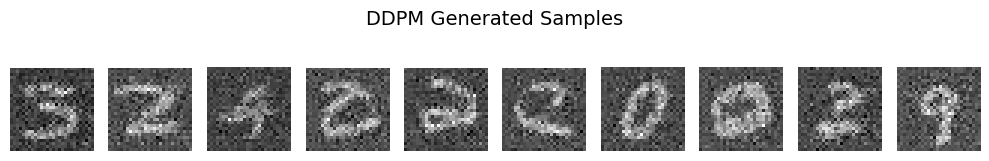

In [ ]:
import matplotlib.pyplot as plt

@torch.no_grad()
def show_diffusion_samples(n=10):
    ddpm.model.eval()
    samples = ddpm.sample(n=n).cpu()  # (n,1,28,28)

    fig, axes = plt.subplots(1, n, figsize=(n, 1.5))
    for i in range(n):
        img = samples[i, 0]

        # Ë∑ü save_image ‰∏ÄÊ®£ÂÅöÊ≠£Ë¶èÂåñ
        img = (img - img.min()) / (img.max() - img.min())

        # Á¶ÅÊ≠¢Ê®°Á≥äÊèíÂÄº ‚Üí ‰øùÊåÅÂÉèÁ¥†Èä≥Âà©
        axes[i].imshow(img, cmap="gray", vmin=0, vmax=1, interpolation="nearest")
        axes[i].axis("off")

    plt.suptitle("DDPM Generated Samples", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()

show_diffusion_samples()

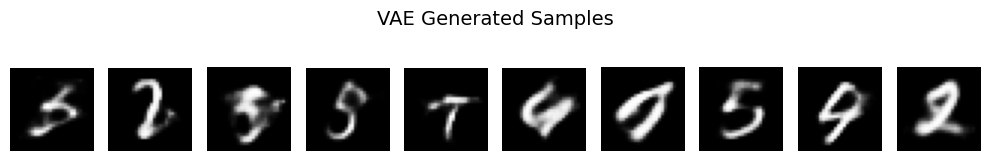

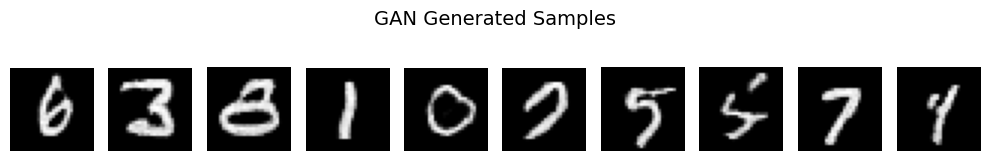

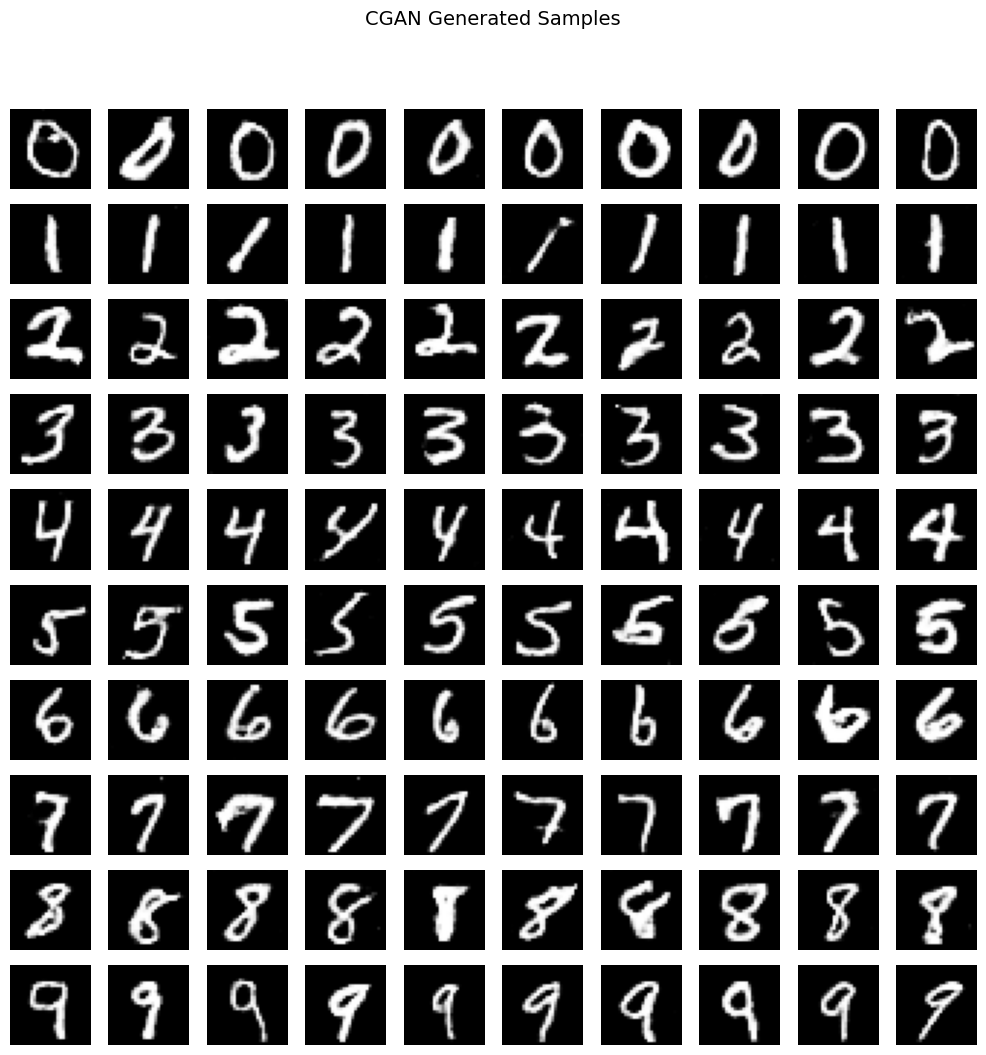

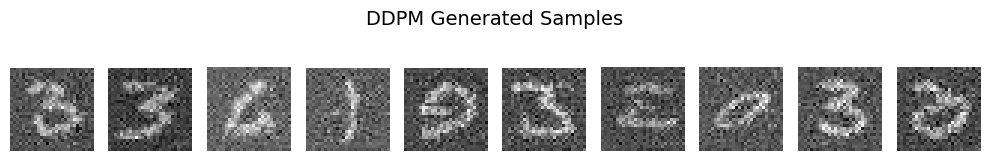

In [ ]:
show_vae_samples()
show_gan_samples()
show_cgan_samples()
show_diffusion_samples()